# 0. Setting up env and import data

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.optim as optim

seed = 100
# Set random seed for reproducibility
np.random.seed(100)
torch.manual_seed(seed)

/var/folders/86/h1q7vkt937n4jdt7nw_1mp040000gn/T/ipykernel_1801/329837619.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv('orders_autumn_2020.csv', sep=',', header=0)
df.head()


,TIMESTAMP,ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES,ITEM_COUNT,USER_LAT,USER_LONG,VENUE_LAT,VENUE_LONG,ESTIMATED_DELIVERY_MINUTES,ACTUAL_DELIVERY_MINUTES,CLOUD_COVERAGE,TEMPERATURE,WIND_SPEED,PRECIPITATION
0,2020-08-01 06:07:00.000,-19,1,60.158,24.946,60.160,24.946,29,10,0.0,15.0,3.53644,0.0
1,2020-08-01 06:17:00.000,-7,8,60.163,24.927,60.153,24.910,39,32,0.0,15.0,3.53644,0.0
2,2020-08-01 06:54:00.000,-17,4,60.161,24.937,60.162,24.939,23,6,0.0,15.0,3.53644,0.0
3,2020-08-01 07:09:00.000,-2,3,60.185,24.954,60.190,24.911,28,26,0.0,16.7,3.52267,0.0
4,2020-08-01 07:10:00.000,-1,2,60.182,24.955,60.178,24.949,27,26,0.0,16.7,3.52267,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18706 entries, 0 to 18705
Data columns (total 13 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   TIMESTAMP                                             18706 non-null  object 
 1   ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES  18706 non-null  int64  
 2   ITEM_COUNT                                            18706 non-null  int64  
 3   USER_LAT                                              18706 non-null  float64
 4   USER_LONG                                             18706 non-null  float64
 5   VENUE_LAT                                             18706 non-null  float64
 6   VENUE_LONG                                            18706 non-null  float64
 7   ESTIMATED_DELIVERY_MINUTES                            18706 non-null  int64  
 8   ACTUAL_DELIVERY_MINUTES                               18

In [4]:
# check if timestamp already in datetime format
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
# extract year, month, day, hour, and minute from timestamp to check if it is correct
df['YEAR'] = df['TIMESTAMP'].dt.year
df['MONTH'] = df['TIMESTAMP'].dt.month
df['DAY'] = df['TIMESTAMP'].dt.day
df['HOUR'] = df['TIMESTAMP'].dt.hour
df['MINUTE'] = df['TIMESTAMP'].dt.minute
df.head()

,TIMESTAMP,ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES,ITEM_COUNT,USER_LAT,USER_LONG,VENUE_LAT,VENUE_LONG,ESTIMATED_DELIVERY_MINUTES,ACTUAL_DELIVERY_MINUTES,CLOUD_COVERAGE,TEMPERATURE,WIND_SPEED,PRECIPITATION,YEAR,MONTH,DAY,HOUR,MINUTE
0,2020-08-01 06:07:00,-19,1,60.158,24.946,60.160,24.946,29,10,0.0,15.0,3.53644,0.0,2020,8,1,6,7
1,2020-08-01 06:17:00,-7,8,60.163,24.927,60.153,24.910,39,32,0.0,15.0,3.53644,0.0,2020,8,1,6,17
2,2020-08-01 06:54:00,-17,4,60.161,24.937,60.162,24.939,23,6,0.0,15.0,3.53644,0.0,2020,8,1,6,54
3,2020-08-01 07:09:00,-2,3,60.185,24.954,60.190,24.911,28,26,0.0,16.7,3.52267,0.0,2020,8,1,7,9
4,2020-08-01 07:10:00,-1,2,60.182,24.955,60.178,24.949,27,26,0.0,16.7,3.52267,0.0,2020,8,1,7,10


# 1. Data Preprocessing

## 1.1. Data cleaning 

### Datatypes

In [5]:
# Check if all attributes are in the correct format
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18706 entries, 0 to 18705
Data columns (total 18 columns):
 #   Column                                                Non-Null Count  Dtype         
---  ------                                                --------------  -----         
 0   TIMESTAMP                                             18706 non-null  datetime64[ns]
 1   ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES  18706 non-null  int64         
 2   ITEM_COUNT                                            18706 non-null  int64         
 3   USER_LAT                                              18706 non-null  float64       
 4   USER_LONG                                             18706 non-null  float64       
 5   VENUE_LAT                                             18706 non-null  float64       
 6   VENUE_LONG                                            18706 non-null  float64       
 7   ESTIMATED_DELIVERY_MINUTES                            18706 non-null  int64 

Almost all attributes are in correct format except the TIMESTAMP. Therefore, we need to convert it to datetime format.

In [6]:
# Convert TIMESTAMP to datetime format
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])

### Time conversion

In [7]:
# Create YEAR, MONTH, DAY, HOUR, MINUTE attributes from TIMESTAMP and also use them to check if the TIMESTAMP was converted correctly
df['YEAR'] = df['TIMESTAMP'].dt.year
df['MONTH'] = df['TIMESTAMP'].dt.month
df['DAY'] = df['TIMESTAMP'].dt.day
df['HOUR'] = df['TIMESTAMP'].dt.hour
df['MINUTE'] = df['TIMESTAMP'].dt.minute
df.head()

,TIMESTAMP,ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES,ITEM_COUNT,USER_LAT,USER_LONG,VENUE_LAT,VENUE_LONG,ESTIMATED_DELIVERY_MINUTES,ACTUAL_DELIVERY_MINUTES,CLOUD_COVERAGE,TEMPERATURE,WIND_SPEED,PRECIPITATION,YEAR,MONTH,DAY,HOUR,MINUTE
0,2020-08-01 06:07:00,-19,1,60.158,24.946,60.160,24.946,29,10,0.0,15.0,3.53644,0.0,2020,8,1,6,7
1,2020-08-01 06:17:00,-7,8,60.163,24.927,60.153,24.910,39,32,0.0,15.0,3.53644,0.0,2020,8,1,6,17
2,2020-08-01 06:54:00,-17,4,60.161,24.937,60.162,24.939,23,6,0.0,15.0,3.53644,0.0,2020,8,1,6,54
3,2020-08-01 07:09:00,-2,3,60.185,24.954,60.190,24.911,28,26,0.0,16.7,3.52267,0.0,2020,8,1,7,9
4,2020-08-01 07:10:00,-1,2,60.182,24.955,60.178,24.949,27,26,0.0,16.7,3.52267,0.0,2020,8,1,7,10


### Missing values

In [8]:
# Check for missing values
print(df.isnull().sum())

# Print a sample of missing values
df[df.isnull().any(axis=1)].head()
# save index of missing values
missing_index = df[df.isnull().any(axis=1)].index
print(list(missing_index))
print(len(missing_index))

TIMESTAMP                                                 0
ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES      0
ITEM_COUNT                                                0
USER_LAT                                                  0
USER_LONG                                                 0
VENUE_LAT                                                 0
VENUE_LONG                                                0
ESTIMATED_DELIVERY_MINUTES                                0
ACTUAL_DELIVERY_MINUTES                                   0
CLOUD_COVERAGE                                          277
TEMPERATURE                                             277
WIND_SPEED                                              277
PRECIPITATION                                             0
YEAR                                                      0
MONTH                                                     0
DAY                                                       0
HOUR                                    

It can be seen that the missing values of CLOUD_COVERAGE, TEMPERATURE, and WIND_SPEED corresponds to all orders in the date 2020-09-10 in the dataset. 

We may want to fill these missing values with the median of the entries in the same hour in that month. But first, let's check for the distribution of these 3 attributes

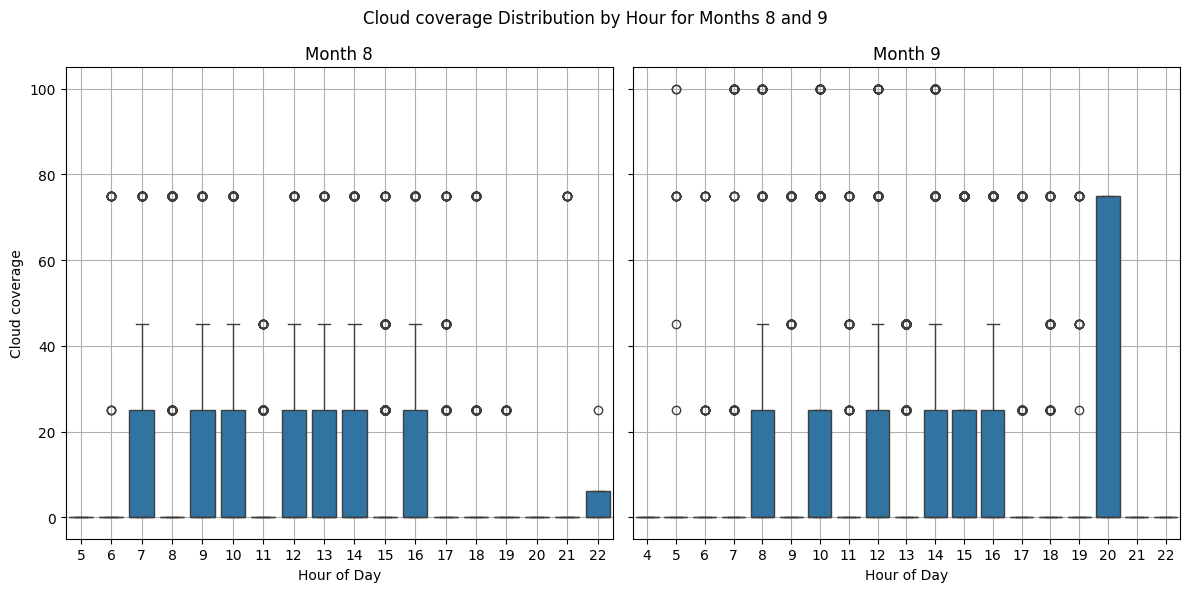

In [9]:
# Plot boxplots for each hour of each month (8 and 9)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)

for i, month in enumerate([8, 9]):
    ax = axes[i]
    monthly_data = df[df['MONTH'] == month]
    sns.boxplot(x='HOUR', y='CLOUD_COVERAGE', data=monthly_data, ax=ax)
    ax.set_title(f'Month {month}')
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Cloud coverage' if i == 0 else '')
    ax.grid(True)

plt.suptitle('Cloud coverage Distribution by Hour for Months 8 and 9')
plt.tight_layout()
plt.show()

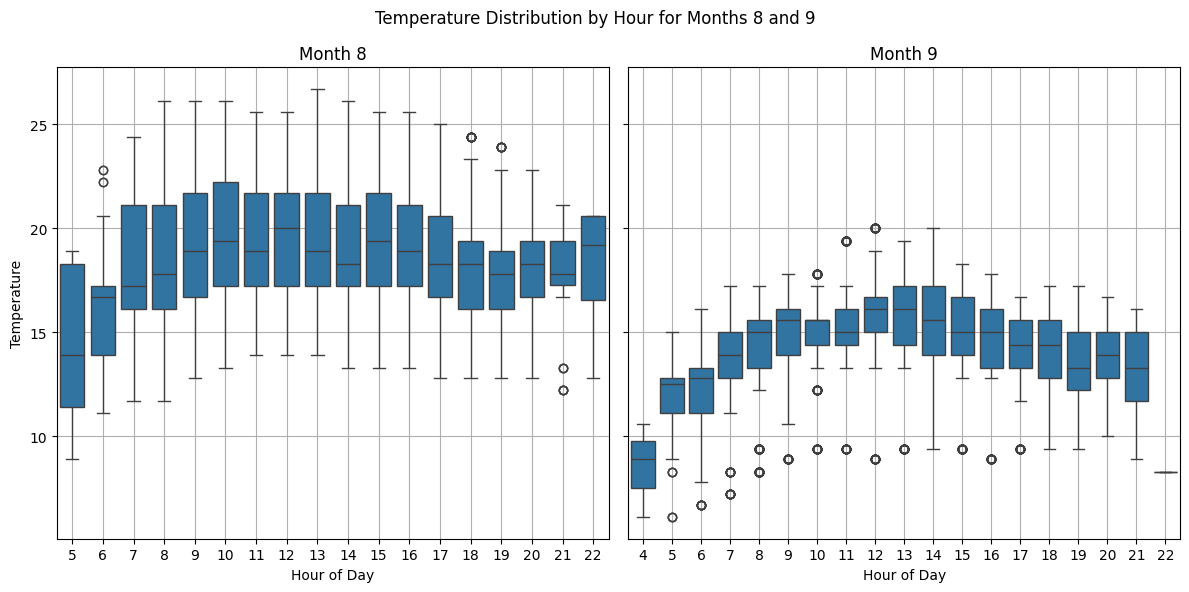

In [10]:
# Plot boxplots for each hour of each month
df = df[df['MONTH'].isin([8, 9])]

# Plot boxplots for each hour of each month (8 and 9)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)

for i, month in enumerate([8, 9]):
    ax = axes[i]
    monthly_data = df[df['MONTH'] == month]
    sns.boxplot(x='HOUR', y='TEMPERATURE', data=monthly_data, ax=ax)
    ax.set_title(f'Month {month}')
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Temperature' if i == 0 else '')
    ax.grid(True)

plt.suptitle('Temperature Distribution by Hour for Months 8 and 9')
plt.tight_layout()
plt.show()

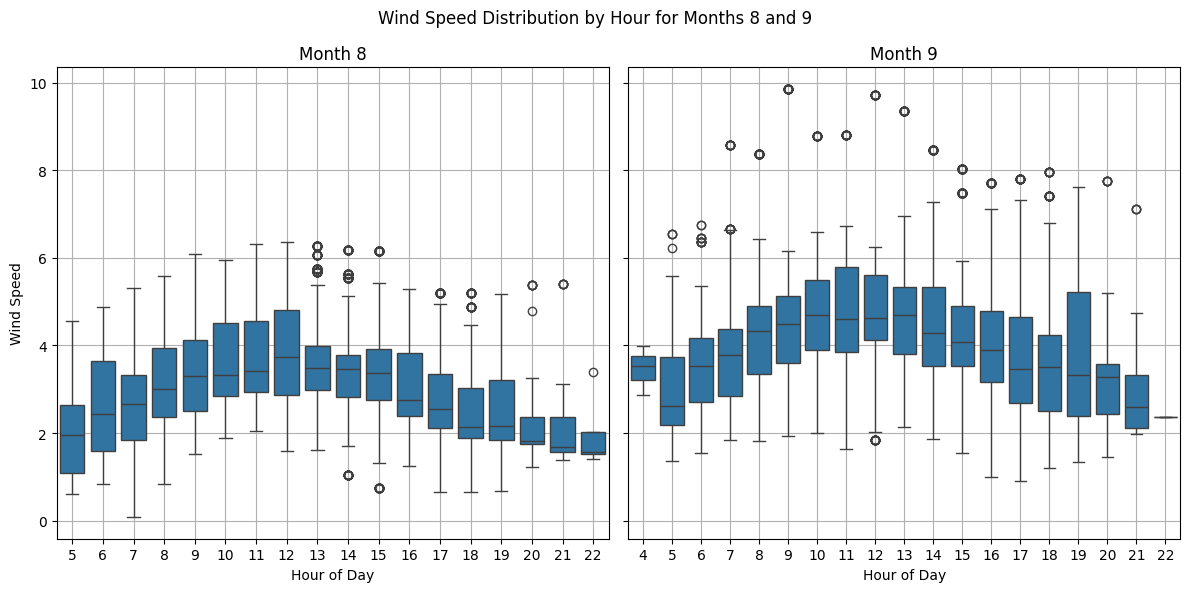

In [11]:
# Plot boxplots for each hour of each month (8 and 9)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)

for i, month in enumerate([8, 9]):
    ax = axes[i]
    monthly_data = df[df['MONTH'] == month]
    sns.boxplot(x='HOUR', y='WIND_SPEED', data=monthly_data, ax=ax)
    ax.set_title(f'Month {month}')
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Wind Speed' if i == 0 else '')
    ax.grid(True)

plt.suptitle('Wind Speed Distribution by Hour for Months 8 and 9')
plt.tight_layout()
plt.show()

Since the deviation of these 3 attributes is quite high, the interquartile length is large, and there are also many outliers, it would not be reasonable to fill the null values with this method. Moreover, since the number of null entries is quite small (277 out of 18,706 entries) and all of them belong to a single day (i.e., 2020-09-01), I decide to drop all of them from the dataset without worrying too much about their contribution to the overall distribution.

In [12]:
# Drop missing values
df = df.dropna()
# Check for missing values again
print(df.isnull().sum())

TIMESTAMP                                               0
ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES    0
ITEM_COUNT                                              0
USER_LAT                                                0
USER_LONG                                               0
VENUE_LAT                                               0
VENUE_LONG                                              0
ESTIMATED_DELIVERY_MINUTES                              0
ACTUAL_DELIVERY_MINUTES                                 0
CLOUD_COVERAGE                                          0
TEMPERATURE                                             0
WIND_SPEED                                              0
PRECIPITATION                                           0
YEAR                                                    0
MONTH                                                   0
DAY                                                     0
HOUR                                                    0
MINUTE        

### Data Transformation

In [13]:
# Create a new attribute WEEKDAY that is 1 if the day is a weekday and 0 if it is a weekend
df['DAY_OF_THE_WEEK'] = df['TIMESTAMP'].dt.dayofweek
df['IS_WEEKDAY'] = df['DAY_OF_THE_WEEK'].apply(lambda x: 1 if x < 4 else 0)
df.head()

,TIMESTAMP,ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES,ITEM_COUNT,USER_LAT,USER_LONG,VENUE_LAT,VENUE_LONG,ESTIMATED_DELIVERY_MINUTES,ACTUAL_DELIVERY_MINUTES,CLOUD_COVERAGE,TEMPERATURE,WIND_SPEED,PRECIPITATION,YEAR,MONTH,DAY,HOUR,MINUTE,DAY_OF_THE_WEEK,IS_WEEKDAY
0,2020-08-01 06:07:00,-19,1,60.158,24.946,60.160,24.946,29,10,0.0,15.0,3.53644,0.0,2020,8,1,6,7,5,0
1,2020-08-01 06:17:00,-7,8,60.163,24.927,60.153,24.910,39,32,0.0,15.0,3.53644,0.0,2020,8,1,6,17,5,0
2,2020-08-01 06:54:00,-17,4,60.161,24.937,60.162,24.939,23,6,0.0,15.0,3.53644,0.0,2020,8,1,6,54,5,0
3,2020-08-01 07:09:00,-2,3,60.185,24.954,60.190,24.911,28,26,0.0,16.7,3.52267,0.0,2020,8,1,7,9,5,0
4,2020-08-01 07:10:00,-1,2,60.182,24.955,60.178,24.949,27,26,0.0,16.7,3.52267,0.0,2020,8,1,7,10,5,0


In [14]:
# Create a new attribute called DELI_DISTANCE that is the distance between the delivery and the restaurant
from geopy.distance import geodesic
# Calculate the distance between the delivery and the restaurant
df['DELI_DISTANCE'] = df.apply(lambda row: geodesic((row['VENUE_LAT'], row['VENUE_LONG']), (row['USER_LAT'], row['USER_LONG'])).km, axis=1)

In [15]:
df.head()

,TIMESTAMP,ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES,ITEM_COUNT,USER_LAT,USER_LONG,VENUE_LAT,VENUE_LONG,ESTIMATED_DELIVERY_MINUTES,ACTUAL_DELIVERY_MINUTES,CLOUD_COVERAGE,...,WIND_SPEED,PRECIPITATION,YEAR,MONTH,DAY,HOUR,MINUTE,DAY_OF_THE_WEEK,IS_WEEKDAY,DELI_DISTANCE
0,2020-08-01 06:07:00,-19,1,60.158,24.946,60.160,24.946,29,10,0.0,...,3.53644,0.0,2020,8,1,6,7,5,0,0.222830
1,2020-08-01 06:17:00,-7,8,60.163,24.927,60.153,24.910,39,32,0.0,...,3.53644,0.0,2020,8,1,6,17,5,0,1.460344
2,2020-08-01 06:54:00,-17,4,60.161,24.937,60.162,24.939,23,6,0.0,...,3.53644,0.0,2020,8,1,6,54,5,0,0.157311
3,2020-08-01 07:09:00,-2,3,60.185,24.954,60.190,24.911,28,26,0.0,...,3.52267,0.0,2020,8,1,7,9,5,0,2.449984
4,2020-08-01 07:10:00,-1,2,60.182,24.955,60.178,24.949,27,26,0.0,...,3.52267,0.0,2020,8,1,7,10,5,0,0.556318


# 2.  Exploratory Data Analysis (EDA)

## Hotspots where most venues located

In [16]:
import folium
from folium.plugins import HeatMap

# Create a map centered around the average latitude
map_center = [df['VENUE_LAT'].mean(), df['VENUE_LONG'].mean()]
m = folium.Map(location=map_center, zoom_start=13)

# Add the heatmap to the map
HeatMap(data=df[['VENUE_LAT', 'VENUE_LONG']], radius=15).add_to(m)
m

The map shows that most venues are at the city center near metro stations where there are many restaurants such as Kamppi, Hakaniemi, and Pasila.

## Hotspots where most users located

In [17]:
# Create a map centered around the average latitude
map_center = [df['USER_LAT'].mean(), df['USER_LONG'].mean()]
m = folium.Map(location=map_center, zoom_start=13)

# Add the heatmap to the map
HeatMap(data=df[['USER_LAT', 'USER_LONG']], radius=15).add_to(m)
m

Unlike venues, users' locations spread across the city quite evenly.

## Delivery Time Accuracy

<Axes: xlabel='DELIVERY_DIFFERENCE', ylabel='Count'>

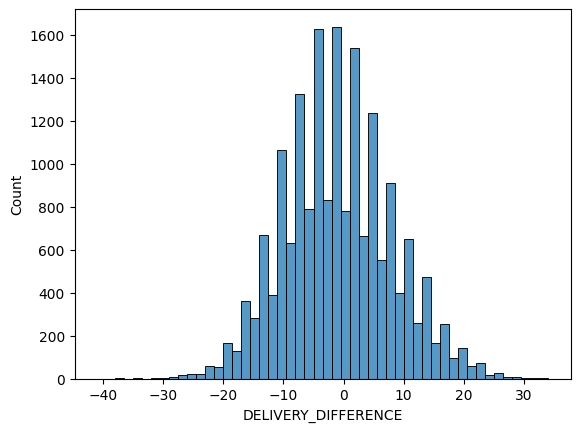

In [18]:
# Distribution of ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES
df['DELIVERY_DIFFERENCE'] = df['ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES']
sns.histplot(data=df, x='DELIVERY_DIFFERENCE', bins=50)

In [19]:
# Proportions of Deliveries within a Certain Timeframe of the Estimate
# Within 5 minutes of the estimate
print(len(df[df['DELIVERY_DIFFERENCE'] <= 5]) / len(df))
# Within 10 minutes of the estimate
print(len(df[df['DELIVERY_DIFFERENCE'] <= 10]) / len(df))
# Within 15 minutes of the estimate
print(len(df[df['DELIVERY_DIFFERENCE'] <= 15]) / len(df))

0.7771447175647078
0.8974442454826632
0.9623419610396657


It can be seen that 96% of the orders are acceptable (i.e. within 15 minutes of the estimate). This pose a need for finding reasons for late deliveries and improving the delivery time. This can be done by finding the factors that affect the delivery time, which is further analyze in section 3: Feature Engineering and Model Prediction

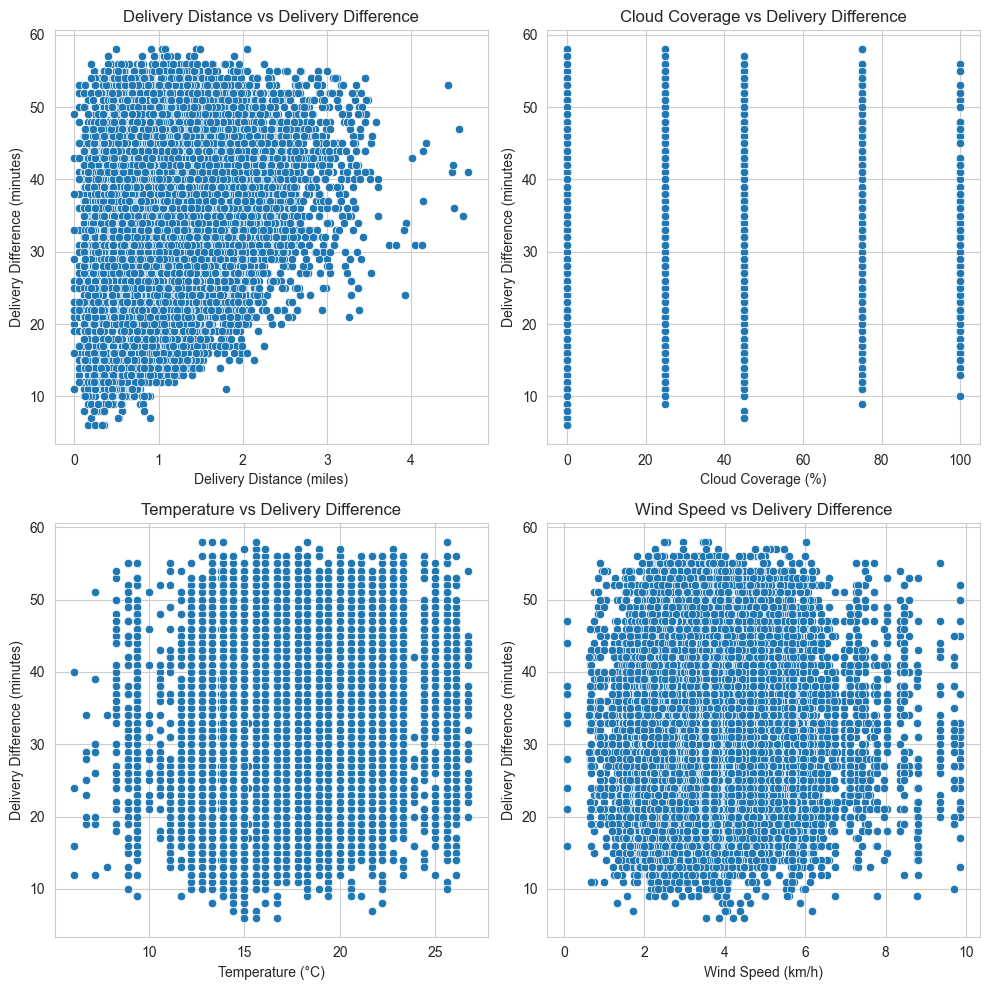

In [20]:
# Set the aesthetic style of the plots
sns.set_style('whitegrid')

# Create a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Flatten the axes array for easy iteration
axs = axs.flatten()

# Plot DELI_DISTANCE vs DELIVERY_DIFFERENCE
sns.scatterplot(data=df, x='DELI_DISTANCE', y='ACTUAL_DELIVERY_MINUTES', ax=axs[0])
axs[0].set_title('Delivery Distance vs Delivery Difference')
axs[0].set_xlabel('Delivery Distance (miles)')
axs[0].set_ylabel('Delivery Difference (minutes)')

# Plot CLOUD_COVERAGE vs DELIVERY_DIFFERENCE
sns.scatterplot(data=df, x='CLOUD_COVERAGE', y='ACTUAL_DELIVERY_MINUTES', ax=axs[1])
axs[1].set_title('Cloud Coverage vs Delivery Difference')
axs[1].set_xlabel('Cloud Coverage (%)')
axs[1].set_ylabel('Delivery Difference (minutes)')

# Plot TEMPERATURE vs DELIVERY_DIFFERENCE
sns.scatterplot(data=df, x='TEMPERATURE', y='ACTUAL_DELIVERY_MINUTES', ax=axs[2])
axs[2].set_title('Temperature vs Delivery Difference')
axs[2].set_xlabel('Temperature (°C)')
axs[2].set_ylabel('Delivery Difference (minutes)')

# Plot WIND_SPEED vs DELIVERY_DIFFERENCE
sns.scatterplot(data=df, x='WIND_SPEED', y='ACTUAL_DELIVERY_MINUTES', ax=axs[3])
axs[3].set_title('Wind Speed vs Delivery Difference')
axs[3].set_xlabel('Wind Speed (km/h)')
axs[3].set_ylabel('Delivery Difference (minutes)')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

## Average Delivery Time by Day of the Week: Identifies if certain days have higher deviations from estimated times

   DAY_OF_THE_WEEK  DELIVERY_DIFFERENCE
0                0            -1.499334
1                1            -1.501525
2                2            -1.563408
3                3            -1.409712
4                4            -1.215665
5                5            -1.133068
6                6            -0.478911


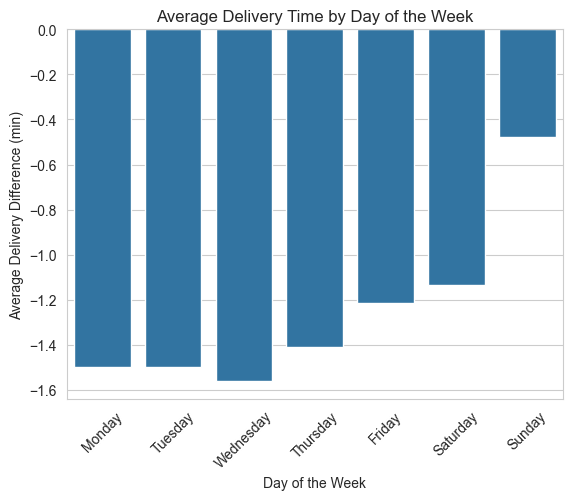

In [21]:
# Convert the delivery day into a categorical type with order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Group by the delivery day and calculate the mean delivery difference
avg_delivery_diff_by_day = df.groupby('DAY_OF_THE_WEEK')['DELIVERY_DIFFERENCE'].mean().reset_index()
print(avg_delivery_diff_by_day)

# Plotting
sns.barplot(data=avg_delivery_diff_by_day, x='DAY_OF_THE_WEEK', y='DELIVERY_DIFFERENCE', order=range(7))
plt.xticks(range(7), day_order, rotation=45)  # Set the xticks labels
plt.xlabel('Day of the Week')
plt.ylabel('Average Delivery Difference (min)')
plt.title('Average Delivery Time by Day of the Week')
plt.show()

### Percentage of Late Deliveries by Day of the Week (> 15 minutes late): Identifies if certain days have more late deliveries

Text(0, 0.5, 'Nunber of Orders')

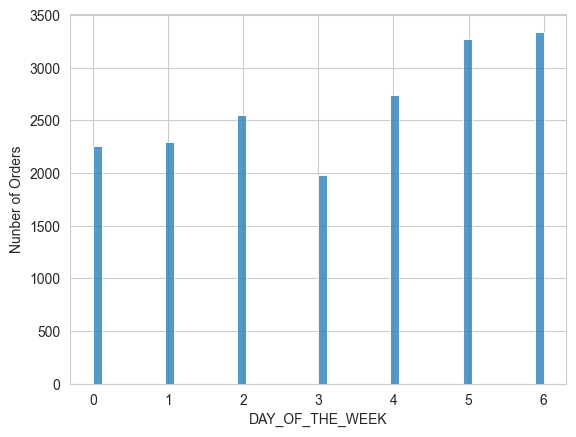

In [22]:
# Histogram of precipitation
sns.histplot(data=df, x='DAY_OF_THE_WEEK', bins=50)
plt.ylabel('Nunber of Orders')

In [23]:
df['LATE_DELIVERY'] = df['DELIVERY_DIFFERENCE'].apply(lambda x: 1 if x > 15 else 0)

LATE_DELIVERY
0    17735
1      694
Name: count, dtype: int64


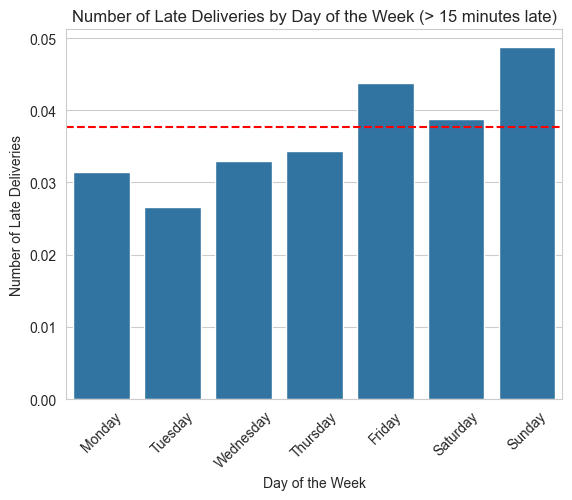

In [24]:
df['LATE_DELIVERY'] = df['DELIVERY_DIFFERENCE'].apply(lambda x: 1 if x > 15 else 0)

print(df['LATE_DELIVERY'].value_counts())

# Group by the delivery day and calculate te percentage of late deliveries
percentage_of_late_delivery_by_day = df.groupby('DAY_OF_THE_WEEK')['LATE_DELIVERY'].mean().reset_index()

# Calculate the overall average percentage of late deliveries
overall_avg_late_delivery = df['LATE_DELIVERY'].mean()

# Plotting
sns.barplot(data=percentage_of_late_delivery_by_day, x='DAY_OF_THE_WEEK', y='LATE_DELIVERY', order=range(7))
plt.axhline(overall_avg_late_delivery, color='red', linestyle='--')  # Add the overall average line
plt.xticks(range(7), day_order, rotation=45)  # Set the xticks labels
plt.xlabel('Day of the Week')
plt.ylabel('Number of Late Deliveries')
plt.title('Number of Late Deliveries by Day of the Week (> 15 minutes late)')
plt.show()

The graph shows that there are noticeably more late deliveries in the weekend and Friday, which makes sense since people tend to order more food in the weekend cause they're not gonna eat at their company's restaurant/canteen. Concretely,
- Weekend Ordering: It's common for people to relax and dine at home during the weekend, leading to an increase in food delivery orders.
- Friday Pattern: Friday is often considered part of the weekend for social and dining purposes, and people may be more inclined to order food on Fridays as well.


### Item Count

Text(0, 0.5, 'Nunber of Orders')

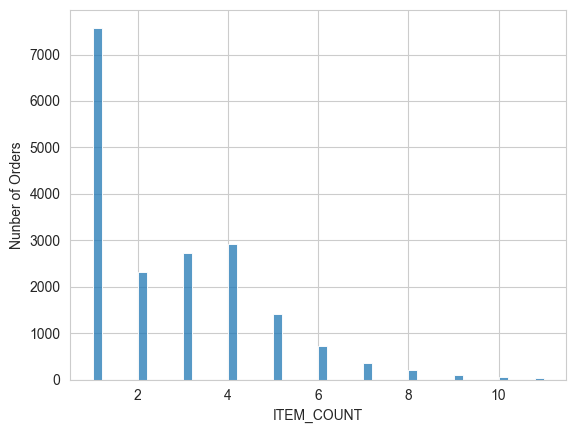

In [25]:
# Histogram of precipitation
sns.histplot(data=df, x='ITEM_COUNT', bins=50)
plt.ylabel('Nunber of Orders')

    ITEM_COUNT  LATE_DELIVERY
0            1       0.034697
1            2       0.035559
2            3       0.033113
3            4       0.043314
4            5       0.049261
5            6       0.042466
6            7       0.041551
7            8       0.042056
8            9       0.040404
9           10       0.015152
10          11       0.120000


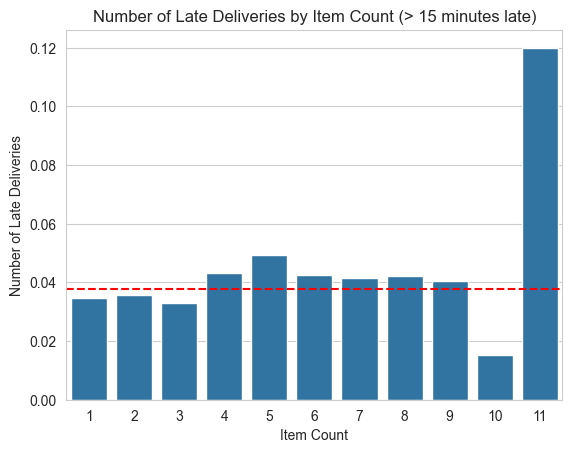

In [26]:
# Group by item count and calculate the percentage of late deliveries
percentage_of_late_delivery_by_ic= df.groupby('ITEM_COUNT')['LATE_DELIVERY'].mean().reset_index()
print(percentage_of_late_delivery_by_ic)

# Calculate the overall average percentage of late deliveries
overall_avg_late_delivery = df['LATE_DELIVERY'].mean()

# Plotting
sns.barplot(data=percentage_of_late_delivery_by_ic, x='ITEM_COUNT', y='LATE_DELIVERY')
plt.axhline(overall_avg_late_delivery, color='red', linestyle='--')  # Add a horizontal line at the overall average
plt.xlabel('Item Count')
plt.ylabel('Number of Late Deliveries')
plt.title('Number of Late Deliveries by Item Count (> 15 minutes late)')
plt.show()

There is a significantly high chance that the order would be late when the number of item is > 11

## Percentage of Late Deliveries by Weather Conditions: Identifies if certain conditions have more late deliveries

### Cloud Coverage

Text(0, 0.5, 'Nunber of Orders')

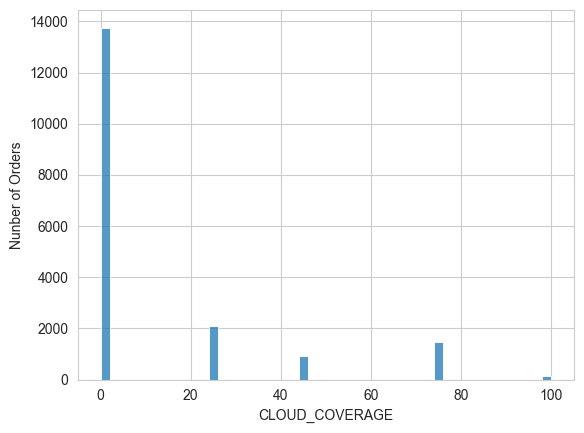

In [27]:
# Histogram of precipitation
sns.histplot(data=df, x='CLOUD_COVERAGE', bins=50)
plt.ylabel('Nunber of Orders')

   CLOUD_COVERAGE  LATE_DELIVERY
0             0.0       0.037427
1            25.0       0.036914
2            45.0       0.035088
3            75.0       0.039005
4           100.0       0.070064


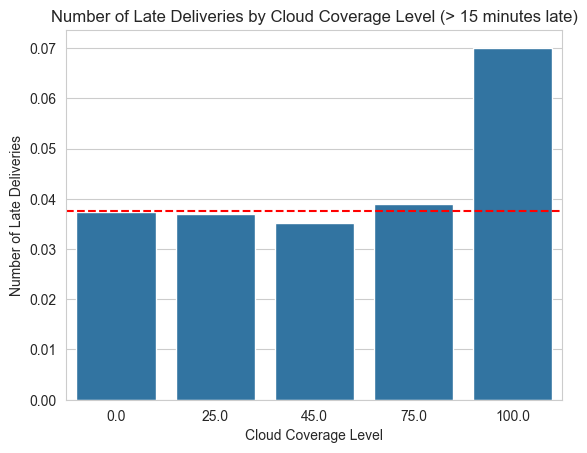

In [28]:
# Group by the cloud coverage level and calculate the percentage of late deliveries
percentage_of_late_delivery_by_cc = df.groupby('CLOUD_COVERAGE')['LATE_DELIVERY'].mean().reset_index()
print(percentage_of_late_delivery_by_cc)

# Calculate the overall average percentage of late deliveries
overall_avg_late_delivery = df['LATE_DELIVERY'].mean()

# Plotting
sns.barplot(data=percentage_of_late_delivery_by_cc, x='CLOUD_COVERAGE', y='LATE_DELIVERY')
plt.axhline(overall_avg_late_delivery, color='red', linestyle='--')  # Add a horizontal line at the overall average
plt.xlabel('Cloud Coverage Level')
plt.ylabel('Number of Late Deliveries')
plt.title('Number of Late Deliveries by Cloud Coverage Level (> 15 minutes late)')
plt.show()

It can be seen that there are more late deliveries when the cloud coverage level is especially high (i.e. 100) since it can be associated with adverse weather conditions such as rain, snow, or storms. These weather conditions may lead to visibility issues, resulting in slower driving speeds or increased caution, contributing to delays.

### Temperature

Text(0, 0.5, 'Nunber of Orders')

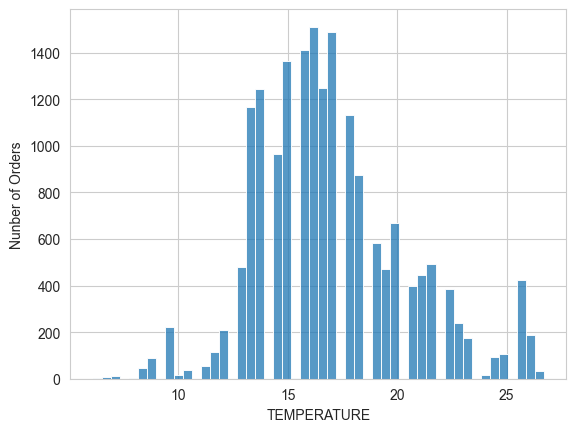

In [29]:
# Histogram of precipitation
sns.histplot(data=df, x='TEMPERATURE', bins=50)
plt.ylabel('Nunber of Orders')

  TEMPERATURE_BIN  LATE_DELIVERY
0       13.3-13.9           1244
1       13.9-15.0           2329
2       15.0-15.6           1418
3       15.6-16.7           2760
4       16.7-17.2           1489
5       17.2-18.3           2003
6       18.3-19.4           1055
7       19.4-21.7           2005
8       21.7-26.7           1665
  TEMPERATURE_BIN  LATE_DELIVERY
0       13.3-13.9       0.032154
1       13.9-15.0       0.034779
2       15.0-15.6       0.040903
3       15.6-16.7       0.041667
4       16.7-17.2       0.047011
5       17.2-18.3       0.036445
6       18.3-19.4       0.036967
7       19.4-21.7       0.034414
8       21.7-26.7       0.031832


/var/folders/86/h1q7vkt937n4jdt7nw_1mp040000gn/T/ipykernel_1801/823009003.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('TEMPERATURE_BIN')['LATE_DELIVERY'].count().reset_index())
/var/folders/86/h1q7vkt937n4jdt7nw_1mp040000gn/T/ipykernel_1801/823009003.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  percentage_of_late_delivery_by_temp = df.groupby('TEMPERATURE_BIN')['LATE_DELIVERY'].mean().reset_index()


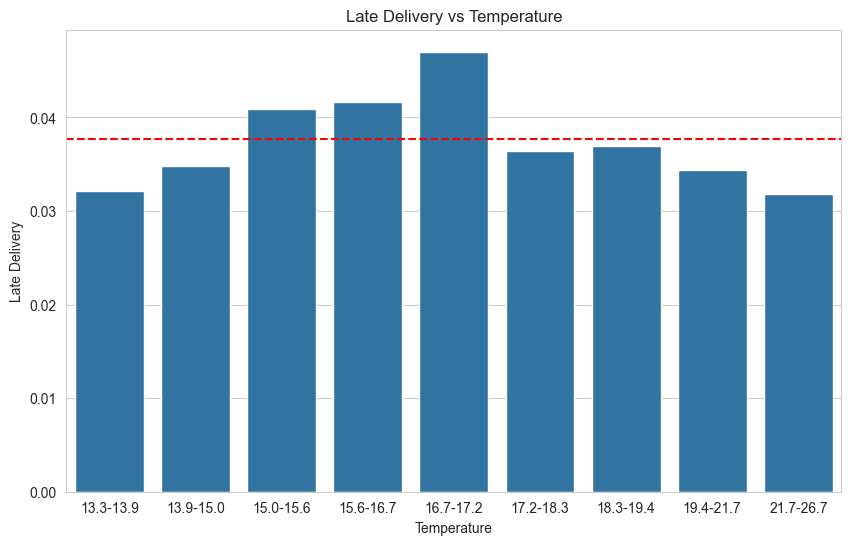

In [30]:
# Define bins and bin labels
# Calculate quantiles for labels
q1 = df['TEMPERATURE'].quantile(0.1)
q2 = df['TEMPERATURE'].quantile(0.2)
q3 = df['TEMPERATURE'].quantile(0.3)
q4 = df['TEMPERATURE'].quantile(0.4)
q5 = df['TEMPERATURE'].quantile(0.5)
q6 = df['TEMPERATURE'].quantile(0.6)
q7 = df['TEMPERATURE'].quantile(0.7)
q8 = df['TEMPERATURE'].quantile(0.8)
q9 = df['TEMPERATURE'].quantile(0.9)
q10 = df['TEMPERATURE'].quantile(1)

labels = [f'{q1}-{q2}', f'{q2}-{q3}', f'{q3}-{q4}', f'{q4}-{q5}', f'{q5}-{q6}', f'{q6}-{q7}', f'{q7}-{q8}', f'{q8}-{q9}', f'{q9}-{q10}']
bins = [q1, q2, q3, q4, q5, q6, q7, q8, q9, q10]

df['TEMPERATURE_BIN'] = pd.cut(df['TEMPERATURE'], bins=bins, labels=labels)

print(df.groupby('TEMPERATURE_BIN')['LATE_DELIVERY'].count().reset_index())
# Group by the temperature and calculate the percentage of late deliveries
percentage_of_late_delivery_by_temp = df.groupby('TEMPERATURE_BIN')['LATE_DELIVERY'].mean().reset_index()
print(percentage_of_late_delivery_by_temp)

# Calculate the overall average percentage of late deliveries
overall_avg_late_delivery = df['LATE_DELIVERY'].mean()

# Draw the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='TEMPERATURE_BIN', y='LATE_DELIVERY', data=percentage_of_late_delivery_by_temp)
plt.axhline(overall_avg_late_delivery, color='red', linestyle='--')  # Add a horizontal line at the overall average
plt.title('Late Delivery vs Temperature')
plt.xlabel('Temperature')
plt.ylabel('Late Delivery')
plt.show()


There's not much noticeable correlation between temperature and the number of rate of late delivery

### Precipitation

Text(0, 0.5, 'Nunber of Orders')

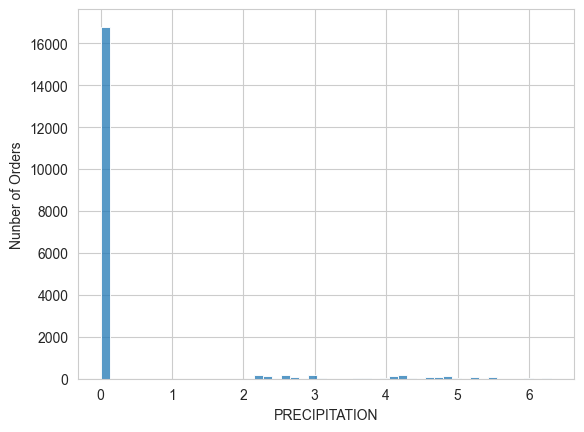

In [31]:
# Histogram of precipitation
sns.histplot(data=df, x='PRECIPITATION', bins=50)
plt.ylabel('Nunber of Orders')

  PRECIPITATION_BIN  LATE_DELIVERY
0                 0       0.036746
1               2-4       0.041333
2                >4       0.051802


/var/folders/86/h1q7vkt937n4jdt7nw_1mp040000gn/T/ipykernel_1801/1723402036.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  percentage_of_late_delivery_by_precip = df.groupby('PRECIPITATION_BIN')['LATE_DELIVERY'].mean().reset_index()


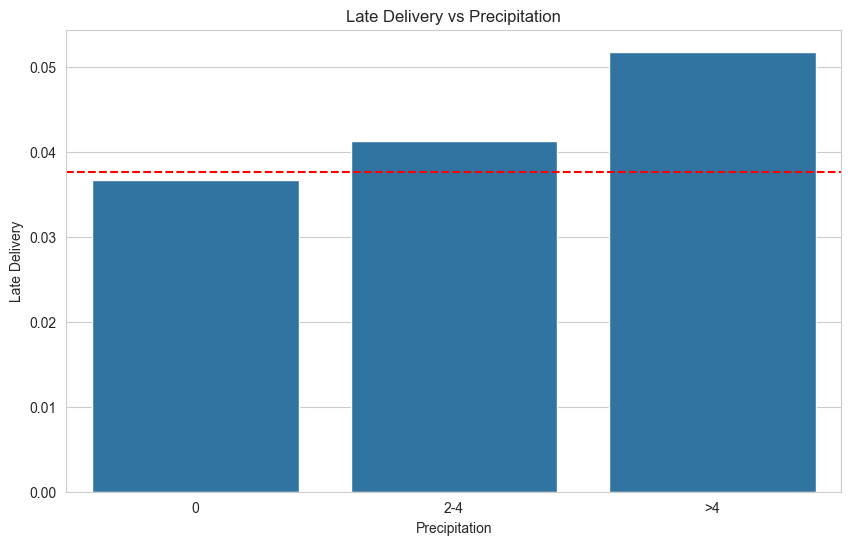

In [32]:
# Through the histogram we could divide the precipitation into 3 bin 0; 2-4; > 4
df['PRECIPITATION_BIN'] = pd.cut(df['PRECIPITATION'], bins=[-1e-8, 2, 4, np.inf], labels=['0', '2-4', '>4'])

# Group by the precipitation and calculate the percentage of late deliveries
percentage_of_late_delivery_by_precip = df.groupby('PRECIPITATION_BIN')['LATE_DELIVERY'].mean().reset_index()
print(percentage_of_late_delivery_by_precip)

# Calculate the overall average percentage of late deliveries
overall_avg_late_delivery = df['LATE_DELIVERY'].mean()

# Draw the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='PRECIPITATION_BIN', y='LATE_DELIVERY', data=percentage_of_late_delivery_by_precip)
plt.axhline(overall_avg_late_delivery, color='red', linestyle='--')  # Add a horizontal line at the overall average
plt.title('Late Delivery vs Precipitation')
plt.xlabel('Precipitation')
plt.ylabel('Late Delivery')
plt.show()

The graph shows that if the precipation is significantly high (> 4), there is a great probability that the delivery would be late.

### Wind Speed

Text(0, 0.5, 'Nunber of Orders')

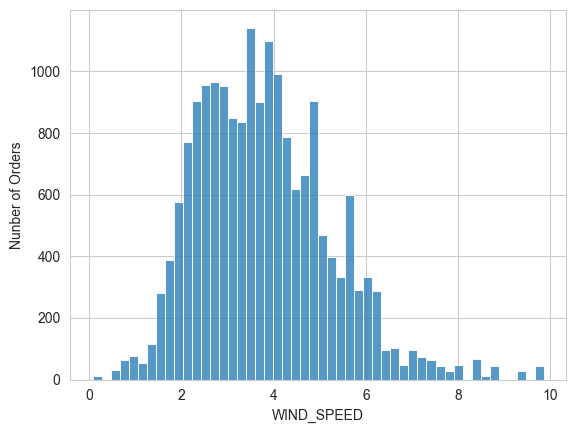

In [33]:
# Histogram of precipitation
sns.histplot(data=df, x='WIND_SPEED', bins=50)
plt.ylabel('Nunber of Orders')

  WIND_SPEED_BIN  LATE_DELIVERY
0         0-2.12       0.027897
1      2.12-2.48       0.030685
2      2.48-2.87       0.028495
3      2.87-3.31       0.034973
4      3.31-3.63       0.035345
5       3.63-4.0       0.037317
6       4.0-4.44       0.048265
7      4.44-4.94       0.046599
8      4.94-5.68       0.049751
9      5.68-9.86       0.037459


/var/folders/86/h1q7vkt937n4jdt7nw_1mp040000gn/T/ipykernel_1801/2129631675.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  percentage_of_late_delivery_by_ws = df.groupby('WIND_SPEED_BIN')['LATE_DELIVERY'].mean().reset_index()


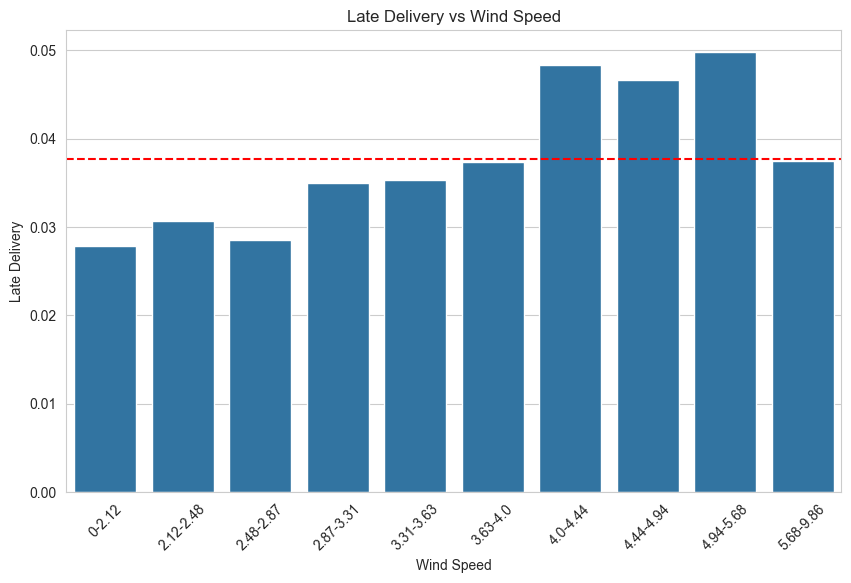

In [34]:
# Define bins and bin labels
# Calculate quantiles for labels
q1 = df['WIND_SPEED'].quantile(0.1)
q2 = df['WIND_SPEED'].quantile(0.2)
q3 = df['WIND_SPEED'].quantile(0.3)
q4 = df['WIND_SPEED'].quantile(0.4)
q5 = df['WIND_SPEED'].quantile(0.5)
q6 = df['WIND_SPEED'].quantile(0.6)
q7 = df['WIND_SPEED'].quantile(0.7)
q8 = df['WIND_SPEED'].quantile(0.8)
q9 = df['WIND_SPEED'].quantile(0.9)
q10 = df['WIND_SPEED'].quantile(1)

labels = [f'0-{q1.round(2)}', f'{q1.round(2)}-{q2.round(2)}', f'{q2.round(2)}-{q3.round(2)}', f'{q3.round(2)}-{q4.round(2)}', f'{q4.round(2)}-{q5.round(2)}', f'{q5.round(2)}-{q6.round(2)}', f'{q6.round(2)}-{q7.round(2)}', f'{q7.round(2)}-{q8.round(2)}', f'{q8.round(2)}-{q9.round(2)}', f'{q9.round(2)}-{q10.round(2)}']
bins = [0-1e-3, q1, q2, q3, q4, q5, q6, q7, q8, q9, q10+1e-3]

df['WIND_SPEED_BIN'] = pd.cut(df['WIND_SPEED'], bins=bins, labels=labels)
# Group by the wind_speed and calculate the percentage of late deliveries
percentage_of_late_delivery_by_ws = df.groupby('WIND_SPEED_BIN')['LATE_DELIVERY'].mean().reset_index()
print(percentage_of_late_delivery_by_ws)

# Calculate the overall average percentage of late deliveries
overall_avg_late_delivery = df['LATE_DELIVERY'].mean()

# Draw the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='WIND_SPEED_BIN', y='LATE_DELIVERY', data=percentage_of_late_delivery_by_ws)
plt.axhline(overall_avg_late_delivery, color='red', linestyle='--')  # Add a horizontal line at the overall average
plt.title('Late Delivery vs Wind Speed')
plt.xticks(rotation=45)
plt.xlabel('Wind Speed')
plt.ylabel('Late Delivery')
plt.show()


There may be a little chance of late delivery when wind speed is in the range of 4 - 5.68

### Hour

Text(0, 0.5, 'Nunber of Orders')

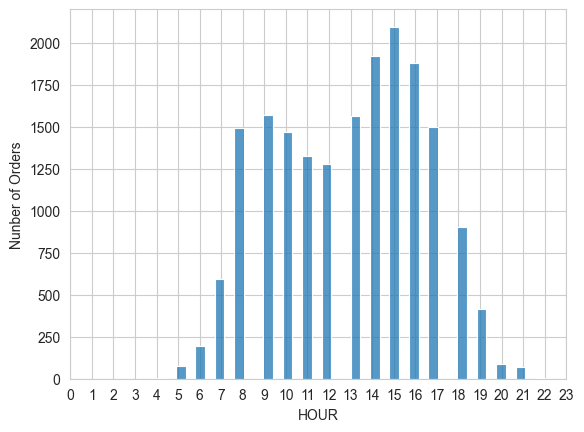

In [35]:
# Histogram of precipitation
sns.histplot(data=df, x='HOUR')
plt.xticks(range(24))
plt.ylabel('Nunber of Orders')

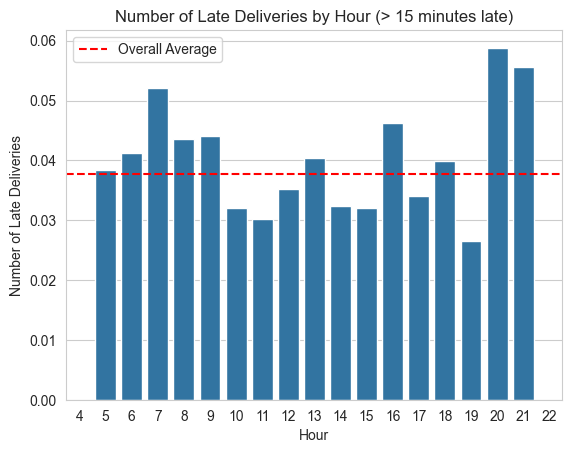

In [36]:
# Group by the hour and calculate the percentage of late deliveries
percentage_of_late_delivery_by_hour = df.groupby('HOUR')['LATE_DELIVERY'].mean().reset_index()

# Calculate the overall average percentage of late deliveries
overall_avg_late_delivery = df['LATE_DELIVERY'].mean()

# Plotting
sns.barplot(data=percentage_of_late_delivery_by_hour, x='HOUR', y='LATE_DELIVERY')
plt.axhline(overall_avg_late_delivery, color='red', linestyle='--', label='Overall Average')
plt.xlabel('Hour')
plt.ylabel('Number of Late Deliveries')
plt.title('Number of Late Deliveries by Hour (> 15 minutes late)')
plt.legend()
plt.show()

The 1st figure shows that there are 2 peak hours in a day which is 8-10 a.m. and 2-4 p.m. However, it doesn't mean there would be more late deliveries in these times. Actually, 7 a.m. and 8-9 p.m. are hours that there is a significantly higher chance of late delivery, as shown in the 2nd figure.

### Delivery Distance

Text(0, 0.5, 'Nunber of Orders')

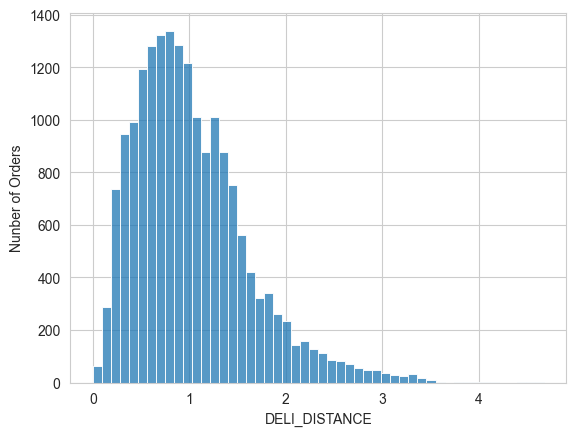

In [37]:
# Histogram of precipitation
sns.histplot(data=df, x='DELI_DISTANCE', bins=50)
plt.ylabel('Nunber of Orders')

  DELI_DISTANCE_BIN  LATE_DELIVERY
0            0-0.36       0.039024
1         0.36-0.53       0.048886
2         0.53-0.67       0.051546
3         0.67-0.79       0.036896
4         0.79-0.92       0.041237
5         0.92-1.06       0.034202
6         1.06-1.24       0.040695
7         1.24-1.45       0.030385
8         1.45-1.79       0.024403
9         1.79-4.67       0.029316


/var/folders/86/h1q7vkt937n4jdt7nw_1mp040000gn/T/ipykernel_1801/3808463117.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  percentage_of_late_delivery_by_distance = df.groupby('DELI_DISTANCE_BIN')['LATE_DELIVERY'].mean().reset_index()


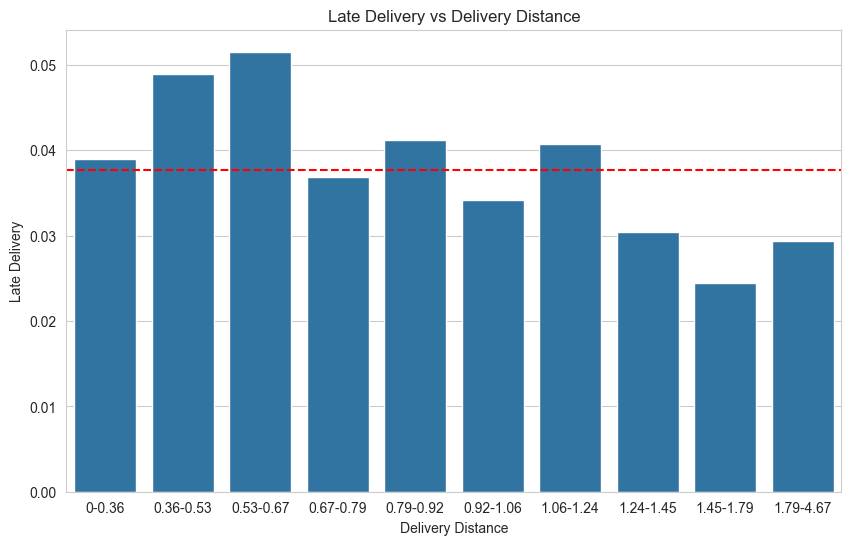

In [38]:
# Calculate quantiles for labels
q1 = df['DELI_DISTANCE'].quantile(0.1)
q2 = df['DELI_DISTANCE'].quantile(0.2)
q3 = df['DELI_DISTANCE'].quantile(0.3)
q4 = df['DELI_DISTANCE'].quantile(0.4)
q5 = df['DELI_DISTANCE'].quantile(0.5)
q6 = df['DELI_DISTANCE'].quantile(0.6)
q7 = df['DELI_DISTANCE'].quantile(0.7)
q8 = df['DELI_DISTANCE'].quantile(0.8)
q9 = df['DELI_DISTANCE'].quantile(0.9)
q10 = df['DELI_DISTANCE'].quantile(1.0)

labels = [f'0-{q1.round(2)}', f'{q1.round(2)}-{q2.round(2)}', f'{q2.round(2)}-{q3.round(2)}', f'{q3.round(2)}-{q4.round(2)}', f'{q4.round(2)}-{q5.round(2)}', f'{q5.round(2)}-{q6.round(2)}', f'{q6.round(2)}-{q7.round(2)}', f'{q7.round(2)}-{q8.round(2)}', f'{q8.round(2)}-{q9.round(2)}', f'{q9.round(2)}-{q10.round(2)}']
bins = [0-1e-3, q1, q2, q3, q4, q5, q6, q7, q8, q9, q10+1e-3]

df['DELI_DISTANCE_BIN'] = pd.cut(df['DELI_DISTANCE'], bins=bins, labels=labels)
# Group by the delivery distance and calculate the percentage of late deliveries
percentage_of_late_delivery_by_distance = df.groupby('DELI_DISTANCE_BIN')['LATE_DELIVERY'].mean().reset_index()
print(percentage_of_late_delivery_by_distance)

# Calculate the overall average percentage of late deliveries
overall_avg_late_delivery = df['LATE_DELIVERY'].mean()

# Draw the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='DELI_DISTANCE_BIN', y='LATE_DELIVERY', data=percentage_of_late_delivery_by_distance)
plt.axhline(overall_avg_late_delivery, color='red', linestyle='--')  # Add a horizontal line at the overall average
plt.title('Late Delivery vs Delivery Distance')
plt.xlabel('Delivery Distance')
plt.ylabel('Late Delivery')
plt.show()


## Delivery time

Text(0, 0.5, 'Nunber of Orders')

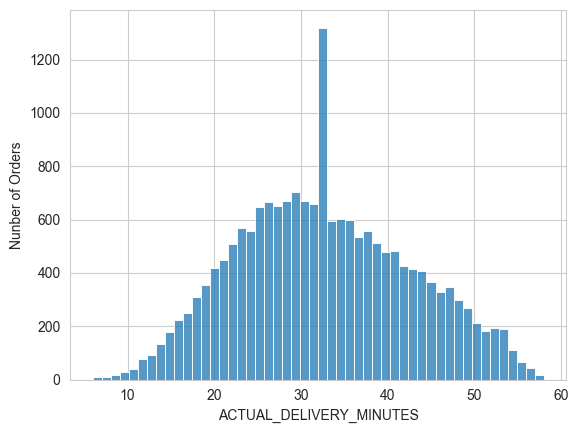

In [39]:
# Histogram of ACTUAL DELIVERY MINUTES
sns.histplot(data=df, x='ACTUAL_DELIVERY_MINUTES', bins=50)
plt.ylabel('Nunber of Orders')

  ESTIMATED_DELIVERY_MINUTES_BIN  LATE_DELIVERY
0                         0-25.0       0.055798
1                      25.0-28.0       0.060738
2                      28.0-29.0       0.079844
3                      29.0-31.0       0.047993
4                      31.0-33.0       0.044921
5                      33.0-35.0       0.043728
6                      35.0-37.0       0.025554
7                      37.0-40.0       0.017704
8                      40.0-44.0       0.000000
9                      44.0-82.0       0.000000


/var/folders/86/h1q7vkt937n4jdt7nw_1mp040000gn/T/ipykernel_1801/3952458424.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  percentage_of_late_delivery_by_est_delivery_minutes = df.groupby('ESTIMATED_DELIVERY_MINUTES_BIN')['LATE_DELIVERY'].mean().reset_index()


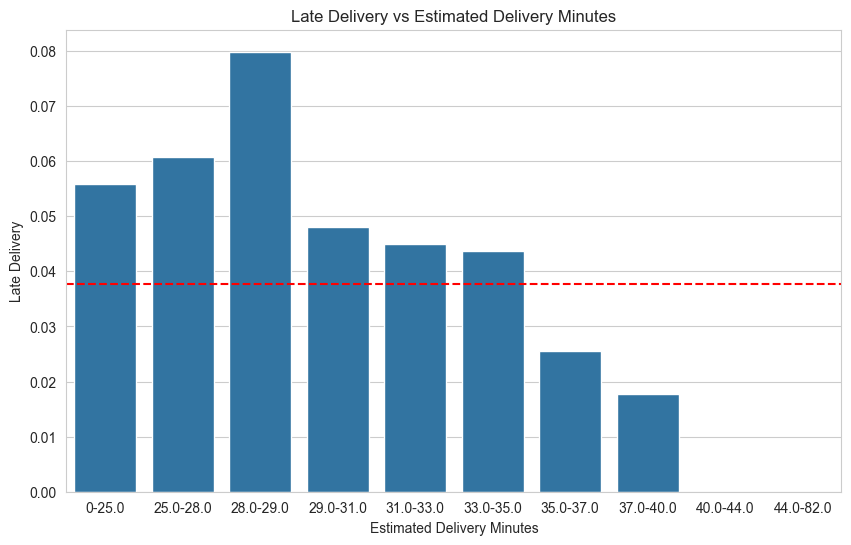

In [40]:
# Calculate quantiles for labels
q1 = df['ESTIMATED_DELIVERY_MINUTES'].quantile(0.1)
q2 = df['ESTIMATED_DELIVERY_MINUTES'].quantile(0.2)
q3 = df['ESTIMATED_DELIVERY_MINUTES'].quantile(0.3)
q4 = df['ESTIMATED_DELIVERY_MINUTES'].quantile(0.4)
q5 = df['ESTIMATED_DELIVERY_MINUTES'].quantile(0.5)
q6 = df['ESTIMATED_DELIVERY_MINUTES'].quantile(0.6)
q7 = df['ESTIMATED_DELIVERY_MINUTES'].quantile(0.7)
q8 = df['ESTIMATED_DELIVERY_MINUTES'].quantile(0.8)
q9 = df['ESTIMATED_DELIVERY_MINUTES'].quantile(0.9)
q10 = df['ESTIMATED_DELIVERY_MINUTES'].quantile(1.0)

labels = [f'0-{q1.round(2)}', f'{q1.round(2)}-{q2.round(2)}', f'{q2.round(2)}-{q3.round(2)}', f'{q3.round(2)}-{q4.round(2)}', f'{q4.round(2)}-{q5.round(2)}', f'{q5.round(2)}-{q6.round(2)}', f'{q6.round(2)}-{q7.round(2)}', f'{q7.round(2)}-{q8.round(2)}', f'{q8.round(2)}-{q9.round(2)}', f'{q9.round(2)}-{q10.round(2)}']
bins = [0-1e-3, q1, q2, q3, q4, q5, q6, q7, q8, q9, q10+1e-3]

df['ESTIMATED_DELIVERY_MINUTES_BIN'] = pd.cut(df['ESTIMATED_DELIVERY_MINUTES'], bins=bins, labels=labels)
# Group by the delivery distance and calculate the percentage of late deliveries
percentage_of_late_delivery_by_est_delivery_minutes = df.groupby('ESTIMATED_DELIVERY_MINUTES_BIN')['LATE_DELIVERY'].mean().reset_index()
print(percentage_of_late_delivery_by_est_delivery_minutes)

# Calculate the overall average percentage of late deliveries
overall_avg_late_delivery = df['LATE_DELIVERY'].mean()

# Draw the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='ESTIMATED_DELIVERY_MINUTES_BIN', y='LATE_DELIVERY', data=percentage_of_late_delivery_by_est_delivery_minutes)
plt.axhline(overall_avg_late_delivery, color='red', linestyle='--')  # Add a horizontal line at the overall average
plt.title('Late Delivery vs Estimated Delivery Minutes')
plt.xlabel('Estimated Delivery Minutes')
plt.ylabel('Late Delivery')
plt.show()


## Regions

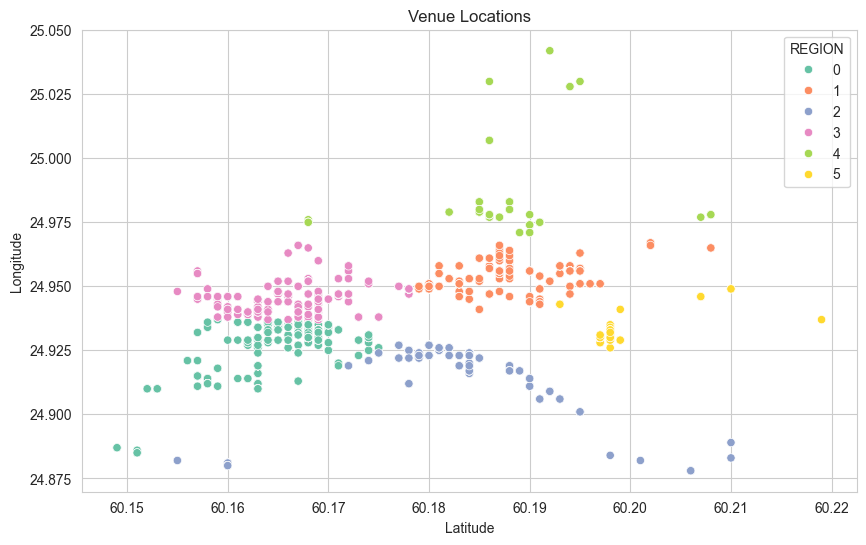

In [41]:
# Create regions based on venue latitude and longitude
# Use K-means clustering to create 6 clusters coreesponding to the 5 regions
from sklearn.cluster import KMeans
# Set seed to produce reproducible results

# Create a new dataframe with the latitude and longitude of the venue
venue_lat_long = df[['VENUE_LAT', 'VENUE_LONG']]
# Create a KMeans object with 6 clusters
kmeans = KMeans(n_clusters=6)
# Fit the KMeans object to the dataset
kmeans.fit(venue_lat_long)
# Create a new attribute called REGION based on the cluster labels
df['REGION'] = kmeans.labels_
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='VENUE_LAT', y='VENUE_LONG', hue='REGION', palette='Set2')
plt.title('Venue Locations')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()


In [42]:
# Create a map centered around the average latitude
cluster_1_center = [df[df['REGION'] == 0]['VENUE_LAT'].mean(), df[df['REGION'] == 0]['VENUE_LONG'].mean()]
cluster_2_center = [df[df['REGION'] == 1]['VENUE_LAT'].mean(), df[df['REGION'] == 1]['VENUE_LONG'].mean()]
cluster_3_center = [df[df['REGION'] == 2]['VENUE_LAT'].mean(), df[df['REGION'] == 2]['VENUE_LONG'].mean()]
cluster_4_center = [df[df['REGION'] == 3]['VENUE_LAT'].mean(), df[df['REGION'] == 3]['VENUE_LONG'].mean()]
cluster_5_center = [df[df['REGION'] == 4]['VENUE_LAT'].mean(), df[df['REGION'] == 4]['VENUE_LONG'].mean()]
cluster_6_center = [df[df['REGION'] == 5]['VENUE_LAT'].mean(), df[df['REGION'] == 4]['VENUE_LONG'].mean()]

# MAP 1
m = folium.Map(location=cluster_1_center, zoom_start=13)
# Add the heatmap to the map
HeatMap(data=df[df['REGION']==0][['VENUE_LAT', 'VENUE_LONG']], radius=15).add_to(m)

# MAP 2
# m = folium.Map(location=cluster_2_center, zoom_start=13)
# HeatMap(data=df[df['REGION']==1][['VENUE_LAT', 'VENUE_LONG']], radius=15).add_to(m)

# MAP 3
# m = folium.Map(location=cluster_3_center, zoom_start=13)
# HeatMap(data=df[df['REGION']==2][['VENUE_LAT', 'VENUE_LONG']], radius=15).add_to(m)

# MAP 4
# m = folium.Map(location=cluster_4_center, zoom_start=13)
# HeatMap(data=df[df['REGION']==3][['VENUE_LAT', 'VENUE_LONG']], radius=15).add_to(m)

# MAP 5
# m = folium.Map(location=cluster_5_center, zoom_start=13)
# HeatMap(data=df[df['REGION']==4][['VENUE_LAT', 'VENUE_LONG']], radius=15).add_to(m)

# MAP 6
# m = folium.Map(location=cluster_6_center, zoom_start=13)
# HeatMap(data=df[df['REGION']==5][['VENUE_LAT', 'VENUE_LONG']], radius=15).add_to(m)

m

In [43]:
# Region labels
region_labels = ['Kamppi', 'Sornainen', 'Toolo', 'Rautatentiori', 'Kalasatama', 'Pasila']

# Map the region labels to the region numbers
df['REGION'] = df['REGION'].apply(lambda x: region_labels[x])

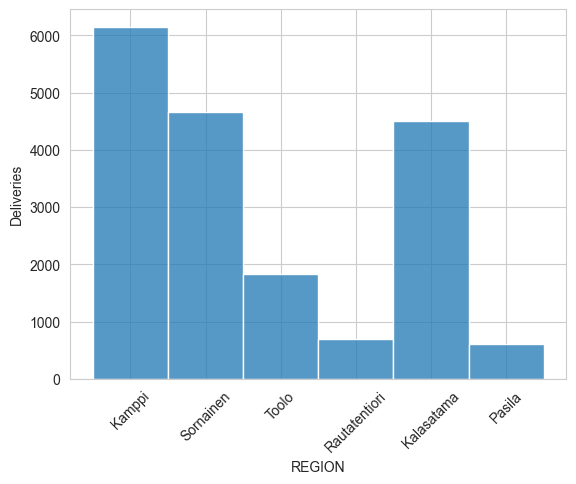

In [44]:
# Histogram of precipitation
sns.histplot(data=df, x='REGION', bins=50)
plt.ylabel('Deliveries')
plt.xticks(range(6), region_labels, rotation=45)
plt.show()

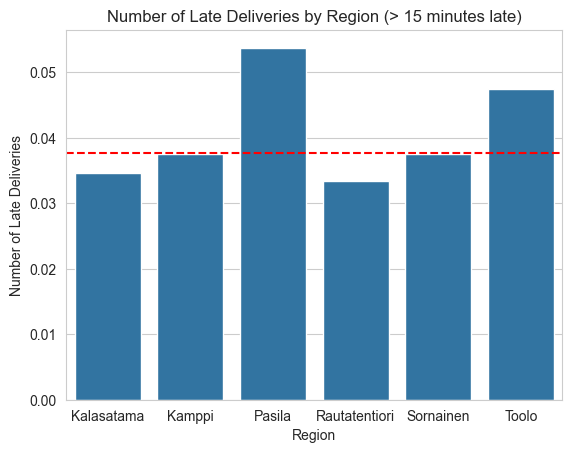

In [45]:
# Group by regions and calculate te percentage of late deliveries
percentage_of_late_delivery_by_region = df.groupby('REGION')['LATE_DELIVERY'].mean().reset_index()

# Calculate the overall average percentage of late deliveries
overall_avg_late_delivery = df['LATE_DELIVERY'].mean()

# Plotting
sns.barplot(data=percentage_of_late_delivery_by_region, x='REGION', y='LATE_DELIVERY')
plt.axhline(overall_avg_late_delivery, color='red', linestyle='--')  # Add the overall average line
# plt.xticks(range(6), region_labels, rotation=45)  # Set the xticks labels
plt.xlabel('Region')
plt.ylabel('Number of Late Deliveries')
plt.title('Number of Late Deliveries by Region (> 15 minutes late)')
plt.show()


# 3. Feature Engineering

In [46]:
# Assign discrete values to the categorical attributes ['DELI_DISTANCE_BIN', 'TEMPERATURE_BIN', 'WIND_SPEED_BIN', 'CLOUD_COVERAGE', 'PRECIPITATION_BIN', 'IS_WEEKDAY']
'''
1. CLOUD_COVERAGE == 100
2. PRECIPITATION > 4
3. WIND_SPEED in range(4, 5.68)
4. HOUR in [7, 20, 21]
5. ITEM_COUNT >= 11
6. Pasila and Toolo REGION
'''
df['CLOUD_COVERAGE'] = df['CLOUD_COVERAGE'].apply(lambda x: 1 if x == 100 else 0)
df['HIGH_PRECIPITATION'] = df['PRECIPITATION'].apply(lambda x: 1 if x > 4 else 0)
df['SPECIAL_WIND_SPEED'] = df['WIND_SPEED'].apply(lambda x: 1 if x >= 4 and x <= 5.68 else 0)
df['SPECIAL_HOUR'] = df['HOUR'].apply(lambda x: 1 if x in [7, 20, 21] else 0)
df['HIGH_ITEM_COUNT'] = df['ITEM_COUNT'].apply(lambda x: 1 if x >= 11 else 0)
df['SPECIAL_REGION'] = df['REGION'].apply(lambda x: 1 if x in ['Pasila', 'Toolo'] else 0)

# 4. Model Fitting

In [91]:
X = df[['CLOUD_COVERAGE', 'HIGH_PRECIPITATION', 'SPECIAL_WIND_SPEED', 'SPECIAL_HOUR', 'HIGH_ITEM_COUNT', 'SPECIAL_REGION']]
y = df['LATE_DELIVERY']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100, stratify=y)

from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids

rus = ClusterCentroids(random_state=100)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

print(X_resampled.shape)
print(y_resampled.shape)

(1110, 6)
(1110,)


/Users/lgk1910/anaconda3/envs/wolt/lib/python3.10/site-packages/sklearn/base.py:1351: ConvergenceWarning: Number of distinct clusters (25) found smaller than n_clusters (555). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


## Random Forest

In [102]:
X = df[['CLOUD_COVERAGE', 'HIGH_PRECIPITATION', 'SPECIAL_WIND_SPEED', 'SPECIAL_HOUR', 'HIGH_ITEM_COUNT', 'SPECIAL_REGION']]
y = df['LATE_DELIVERY']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids

rus = ClusterCentroids(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# Initialize the Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
rf.fit(X_resampled, y_resampled)

# Get feature importances
importances = rf.feature_importances_

# Sort the feature importances in descending order
sorted_indices = np.argsort(importances)[::-1]

# Print the feature rankings
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(f"{f + 1}. feature {sorted_indices[f]} ({importances[sorted_indices[f]]})")

# Validate the model
from sklearn.metrics import classification_report
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

Feature ranking:
1. feature 2 (0.5948528706914806)
2. feature 5 (0.22430350943820027)
3. feature 3 (0.08772110996851282)
4. feature 1 (0.061232605047417586)
5. feature 0 (0.026169142098697615)
6. feature 4 (0.005720762755691193)
              precision    recall  f1-score   support

           0       0.97      0.57      0.72      3547
           1       0.05      0.61      0.10       139

    accuracy                           0.57      3686
   macro avg       0.51      0.59      0.41      3686
weighted avg       0.94      0.57      0.69      3686



/Users/lgk1910/anaconda3/envs/wolt/lib/python3.10/site-packages/sklearn/base.py:1351: ConvergenceWarning: Number of distinct clusters (24) found smaller than n_clusters (555). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


(array([0, 1]), array([555, 555]))
Feature ranking:
1. feature 1 (0.38016519204530236)
2. feature 4 (0.2251335245386032)
3. feature 3 (0.2032477630018203)
4. feature 0 (0.11624095042298438)
5. feature 10 (0.03635863487656935)
6. feature 7 (0.014120110575507569)
7. feature 6 (0.009767161597284975)
8. feature 8 (0.00853453573933423)
9. feature 2 (0.0024538329856941678)
10. feature 5 (0.0023570058574543438)
11. feature 9 (0.001621288359444888)
              precision    recall  f1-score   support

           0       0.97      0.41      0.57      3547
           1       0.04      0.68      0.08       139

    accuracy                           0.42      3686
   macro avg       0.51      0.54      0.33      3686
weighted avg       0.93      0.42      0.55      3686



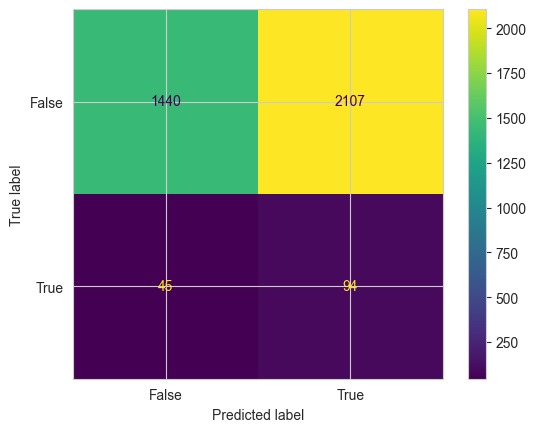

In [99]:
# Initialize the Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
rf.fit(X_resampled, y_resampled)
print(np.unique(y_resampled, return_counts=True))
# rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_

# Sort the feature importances in descending order
sorted_indices = np.argsort(importances)[::-1]

# Print the feature rankings
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(f"{f + 1}. feature {sorted_indices[f]} ({importances[sorted_indices[f]]})")

# Validate the model
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))
# confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_display.plot()
plt.show()

## AdaBoost

In [94]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create a base classifier (e.g., Decision Tree)
base_classifier = DecisionTreeClassifier(max_depth=1)

# Create the AdaBoost classifier
adaboost_classifier = AdaBoostClassifier(base_classifier, n_estimators=50, random_state=42)

# Fit the model
adaboost_classifier.fit(X_resampled, y_resampled)

# Make predictions
y_pred = adaboost_classifier.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.97      0.60      0.74      3547
           1       0.05      0.58      0.10       139

    accuracy                           0.59      3686
   macro avg       0.51      0.59      0.42      3686
weighted avg       0.94      0.59      0.71      3686



/Users/lgk1910/anaconda3/envs/wolt/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


## XGBoost

In [104]:
import xgboost as xgb

# Create an XGBoost classifier
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Train the model
xgb_classifier.fit(X_resampled, y_resampled)

# Make predictions
y_pred = xgb_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Additional evaluation metrics
print(classification_report(y_test, y_pred))

Accuracy: 0.5730
              precision    recall  f1-score   support

           0       0.97      0.57      0.72      3547
           1       0.05      0.60      0.10       139

    accuracy                           0.57      3686
   macro avg       0.51      0.58      0.41      3686
weighted avg       0.94      0.57      0.70      3686



## RNN

In [48]:
# Count number of orders every single day
df.groupby(['YEAR', 'MONTH', 'DAY'])['TIMESTAMP'].count().reset_index()

,YEAR,MONTH,DAY,TIMESTAMP
0,2020,8,1,299
1,2020,8,2,328
2,2020,8,3,226
3,2020,8,4,228
4,2020,8,5,256
5,2020,8,6,298
6,2020,8,7,284
7,2020,8,8,293
8,2020,8,9,359
9,2020,8,10,267


In [47]:
device = 'mps'

# Define the RNN model
class RNNTimeSeriesModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, current_features_size, device=None):
        super(RNNTimeSeriesModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        if device:
            self.device = device
        else:
            self.device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

        # Define an RNN layer
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True).to(self.device)
        
        self.fc = nn.Linear(hidden_size + current_features_size, output_size).to(self.device)


    def forward(self, x, current_features):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        
        # Combine the output of the last time step with the current features
        out = torch.cat((out[:, -1, :], current_features), dim=1)

        # Pass the output of the last time step to the output layer
        out = self.fc(out)
        return out

# Define the LSTM model
class LSTMTimeSeriesModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, current_features_size, device=None):
        super(LSTMTimeSeriesModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        if device:
            self.device = device
        else:
            self.device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

        # Define an LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True).to(self.device)
        
        self.fc = nn.Linear(hidden_size + current_features_size, output_size).to(self.device)


    def forward(self, x, current_features):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        
        # Forward propagate the LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Combine the output of the last time step with the current features
        out = torch.cat((out[:, -1, :], current_features), dim=1)

        # Pass the output of the last time step to the output layer
        out = self.fc(out)
        return out

### Data Preparation


In [48]:
# Convert DataFrame to PyTorch Tensors
def create_sequences(dataframe, feature_columns, target_column, sequence_length):
    sequences = []
    current_features = []
    targets = []
    
    data = dataframe[feature_columns + [target_column]].values
    current_data = dataframe[feature_columns].values
    target_data = dataframe[target_column].values
    
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
        current_features.append(current_data[i+sequence_length])
        targets.append(target_data[i+sequence_length])
    
    return torch.tensor(sequences, dtype=torch.float32), torch.tensor(current_features, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32).view(-1, 1)

def denormalize_target(value, target_column, normalization_parameters):
    params = normalization_parameters[target_column]
    return (value * params['std']) + params['mean']

def calculate_normalization_parameters(df, feature_columns, target_column, split_index):
    # Define a dictionary to store the mean and std for each feature only using training data
    normalization_parameters = {}
    for column in feature_columns + [target_column]:
        # Store the mean and std of the data
        if column == target_column:
            normalization_parameters[column] = {'mean': 0, 'std': 1}
        else:
            normalization_parameters[column] = {'mean': df[:split_index][column].mean(), 'std': df[:split_index][column].std()}
    return normalization_parameters

# feature_columns = ['DELI_DISTANCE', 'ITEM_COUNT', 'CLOUD_COVERAGE', 'TEMPERATURE', 'WIND_SPEED']
feature_columns = ['DELI_DISTANCE', 'ITEM_COUNT', 'CLOUD_COVERAGE', 'TEMPERATURE', 'WIND_SPEED', 'HIGH_PRECIPITATION', 'SPECIAL_WIND_SPEED', 'SPECIAL_HOUR', 'HIGH_ITEM_COUNT', 'SPECIAL_REGION']
target_column = 'ACTUAL_DELIVERY_MINUTES'
window_length = 100

split_frac = 0.8
split_index = int(split_frac * len(df))

normalization_parameters = calculate_normalization_parameters(df, feature_columns, target_column, split_index=split_index)

# Normalize the data using the normalization parameters
df_norm = df.copy()
for column in feature_columns + [target_column]:
    df_norm[column] = (df[column] - normalization_parameters[column]['mean']) / normalization_parameters[column]['std']

# Split the data
train_data = df_norm[:split_index]
test_data = df_norm[split_index:]

# Create training set
X_train, current_features_train, y_train = create_sequences(train_data, feature_columns, target_column, window_length)

# Create test set
additional_data_for_test = train_data.iloc[-window_length:]
test_data_prepended = pd.concat([additional_data_for_test, test_data]).reset_index(drop=True)
X_test, current_features_test, y_test = create_sequences(test_data_prepended, feature_columns, target_column, window_length)
# Correct the sequences by discarding the first window_length sequences
X_test_corrected = X_test[window_length:]
current_features_test_corrected = current_features_test[window_length:]
y_test_corrected = y_test[window_length:]

/var/folders/86/h1q7vkt937n4jdt7nw_1mp040000gn/T/ipykernel_2119/1407512610.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:264.)
  return torch.tensor(sequences, dtype=torch.float32), torch.tensor(current_features, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32).view(-1, 1)


In [49]:
# Assign all to device
X_train = X_train.to(device)
current_features_train = current_features_train.to(device)
y_train = y_train.to(device)
X_test_corrected = X_test_corrected.to(device)
current_features_test_corrected = current_features_test_corrected.to(device)
y_test_corrected = y_test_corrected.to(device)

print(X_train.shape)
print(current_features_train.shape)
print(y_train.shape)
print(X_test_corrected.shape)
print(current_features_test_corrected.shape)
print(y_test_corrected.shape)

torch.Size([14643, 100, 11])
torch.Size([14643, 10])
torch.Size([14643, 1])
torch.Size([3586, 100, 11])
torch.Size([3586, 10])
torch.Size([3586, 1])


In [50]:
# Estimated delivery time in the dataframe
y_est = df['ESTIMATED_DELIVERY_MINUTES'].iloc[split_index:].values
print(y_est.shape)

(3686,)


### Time-series Data Visualization - Actual Delivery Time vs Estimate Delivery Time

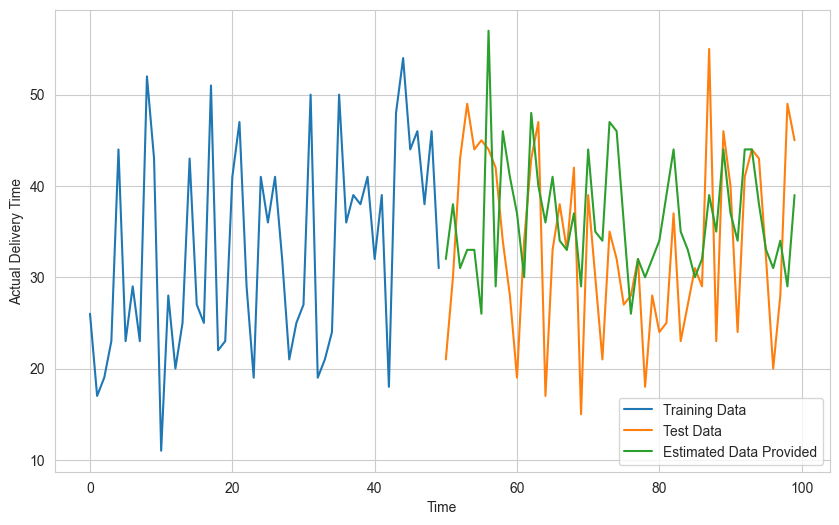

In [51]:
# Plot the training and test data
plt.figure(figsize=(10, 6))
plt.plot(denormalize_target(y_train[-50:].cpu().numpy(), target_column, normalization_parameters), label='Training Data')
plt.plot(np.arange(50, 50+50), denormalize_target(y_test[:50], target_column, normalization_parameters), label='Test Data')
plt.plot(np.arange(50, 50+50), y_est[:50], label='Estimated Data Provided')
plt.xlabel('Time')
plt.ylabel('Actual Delivery Time')
plt.legend()
plt.show()

### Training Model

In [52]:
# Hyperparameters
input_size = len(feature_columns) + 1
hidden_size = 64
num_layers = 3
output_size = 1

# Create the model
# model = RNNTimeSeriesModel(input_size, hidden_size, num_layers, output_size, current_features_size=len(feature_columns))
model = LSTMTimeSeriesModel(input_size, hidden_size, num_layers, output_size, current_features_size=len(feature_columns))

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model with batch training
batch_size = 1000
num_epochs = 1000
total_samples = X_train.shape[0]
num_batches = total_samples // batch_size
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    
    # Shuffle the training data
    indices = torch.randperm(total_samples)
    X_train_shuffled = X_train[indices]
    current_features_train_shuffled = current_features_train[indices]
    y_train_shuffled = y_train[indices]

    for batch in range(num_batches):
        # Get the current batch
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size
        batch_X = X_train_shuffled[start_idx:end_idx]
        batch_current_features = current_features_train_shuffled[start_idx:end_idx]
        batch_y = y_train_shuffled[start_idx:end_idx]

        # Forward pass
        outputs = model(batch_X, batch_current_features)
        optimizer.zero_grad()
        loss = criterion(outputs, batch_y)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    if (epoch+1) % 100 == 0:
        # Save the model checkpoint
        torch.save(model.state_dict(), f'lstm_model_{epoch+1}.pth')
        print(f'Model trained and saved as lstm_model_{epoch+1}.pth')
    
    # Calculate training and testing loss and save them in a list for plotting
    model.eval()
    with torch.no_grad():
        # Make predictions
        train_predictions = model(X_train, current_features_train)
        test_predictions = model(X_test_corrected, current_features_test_corrected)

        # Calculate the loss
        train_loss = criterion(train_predictions, y_train)
        test_loss = criterion(test_predictions, y_test_corrected)

        # Save the losses
        train_losses.append(train_loss.item())
        test_losses.append(test_loss.item())

    # Save losses
    np.save('lstm_train_losses.npy', np.array(train_losses))
    np.save('lstm_test_losses.npy', np.array(test_losses))

# Save the model checkpoint
torch.save(model.state_dict(), 'lstm_model.pth')
print('Model trained and saved as rnn_model.pth')

# Save losses
np.save('lstm_train_losses.npy', np.array(train_losses))
np.save('lstm_test_losses.npy', np.array(test_losses))

# Plot the training and test losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

RuntimeError: MPS backend out of memory (MPS allocated: 599.00 MB, other allocations: 15.48 GB, max allowed: 18.13 GB). Tried to allocate 4.19 GB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [76]:
# Hyperparameters
input_size = len(feature_columns) + 1
hidden_size = 64
num_layers = 3
output_size = 1

# Create the model
# model = RNNTimeSeriesModel(input_size, hidden_size, num_layers, output_size, current_features_size=len(feature_columns))
model = LSTMTimeSeriesModel(input_size, hidden_size, num_layers, output_size, current_features_size=len(feature_columns))

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 2000
for epoch in range(num_epochs):
    model.train()

    # Forward pass
    outputs = model(X_train, current_features_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Save the model checkpoint
torch.save(model.state_dict(), 'rnn_model.pth')
print('Model trained and saved as rnn_model.pth')

In [55]:
def denormalized_features(features, feature_columns, normalization_parameters):
    denormalized_features = []
    for i, feature in enumerate(feature_columns):
        params = normalization_parameters[feature]
        denormalized_features.append((features[i] * params['std']) + params['mean'])
    return denormalized_features

In [56]:
print(df.iloc[split_index+window_length])

TIMESTAMP                                               2020-09-19 17:05:00
ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES                     -5
ITEM_COUNT                                                                1
USER_LAT                                                             60.184
USER_LONG                                                            24.961
VENUE_LAT                                                            60.168
VENUE_LONG                                                           24.952
ESTIMATED_DELIVERY_MINUTES                                               44
ACTUAL_DELIVERY_MINUTES                                                  39
CLOUD_COVERAGE                                                            0
TEMPERATURE                                                            12.2
WIND_SPEED                                                          3.82067
PRECIPITATION                                                           0.0
YEAR        

In [67]:
print(denormalized_features(current_features_test_corrected[0], feature_columns, normalization_parameters))
print(denormalize_target(y_test_corrected.cpu().numpy(), target_column, normalization_parameters)[0])
print(y_est[window_length])
# print(X_test_corrected[0])


[tensor(1.8513, device='mps:0'), tensor(1., device='mps:0'), tensor(0., device='mps:0'), tensor(12.2000, device='mps:0'), tensor(3.8207, device='mps:0'), tensor(0., device='mps:0'), tensor(2.9802e-08, device='mps:0'), tensor(-3.7253e-09, device='mps:0'), tensor(-1.1642e-10, device='mps:0'), tensor(0., device='mps:0')]
[39.]
44


In [68]:
# Calculate the test loss
model.eval()
with torch.no_grad():
    outputs = model(X_test_corrected, current_features_test_corrected)

    denormalized_y_pred, denormalized_y_test = denormalize_target(outputs.cpu().numpy(), target_column, normalization_parameters), denormalize_target(y_test_corrected.cpu().numpy(), target_column, normalization_parameters)
    # MSE loss of two numpy arrays
    loss = criterion(torch.tensor(denormalized_y_pred, dtype=torch.float32).view(-1, 1), torch.tensor(denormalized_y_test, dtype=torch.float32).view(-1, 1))
    print(f'Test loss: {loss.item():.4f}')

# Check number of late deliveries
late_deliveries = 0
for i in range(len(denormalized_y_pred)):
    if denormalized_y_test[i] - denormalized_y_pred[i] > 15:
        late_deliveries += 1
print(late_deliveries)

# Compare to the baseline of given estimated delivery time
baseline_loss = criterion(torch.tensor(y_est[window_length:], dtype=torch.float32).view(-1, 1), torch.tensor(denormalized_y_test, dtype=torch.float32).view(-1, 1))
print(f'Baseline loss: {baseline_loss.item():.4f}')
# Check number of late deliveries of the baseline
late_deliveries = 0
for i in range(len(denormalized_y_pred)):
    if denormalized_y_test[i] - y_est[window_length + i] > 15:
        late_deliveries += 1
print(late_deliveries)


Test loss: 212.4446
513
Baseline loss: 85.2769
121


In [70]:
# Use the prediction to predict if the delivery is late
y_pred = []
print(len(denormalized_y_pred))
print(len(df['LATE_DELIVERY'][split_index+window_length:]))

# for i in range(len(denormalized_y_pred)):
n = 1000
for i in range(n):
    if denormalized_y_pred[i] - y_est[window_length + i] > 15:
        y_pred.append(1)
    
    else:    
        y_pred.append(0)

# y_pred = np.array(y_pred)
# tmp = np.array(df['LATE_DELIVERY'].iloc[split_index+window_length:split_index+window_length+n])
# for i in range(n):
#     if repr(y_pred[i]) != repr(tmp[i]):
#         print(repr(y_pred[i]), repr(tmp[i]))
#         print(y_pred[i], tmp[i])
#         print('-----')
        # print(i, y_pred[i], df['LATE_DELIVERY'][split_index+window_length+i])
        # print(y_pred[i] - df['LATE_DELIVERY'][split_index+window_length+i])
        # print(type(y_pred[i]), type(df['LATE_DELIVERY'][split_index+window_length+i]))

# print(np.array(y_pred) - np.array(df['LATE_DELIVERY'][split_index+window_length:split_index+window_length+n]))


print(classification_report(df['LATE_DELIVERY'][split_index+window_length:split_index+window_length+n], y_pred))

3666
3666
              precision    recall  f1-score   support

           0       0.96      0.89      0.92       959
           1       0.06      0.17      0.09        41

    accuracy                           0.86      1000
   macro avg       0.51      0.53      0.51      1000
weighted avg       0.92      0.86      0.89      1000



11.683618
7.451445701274466


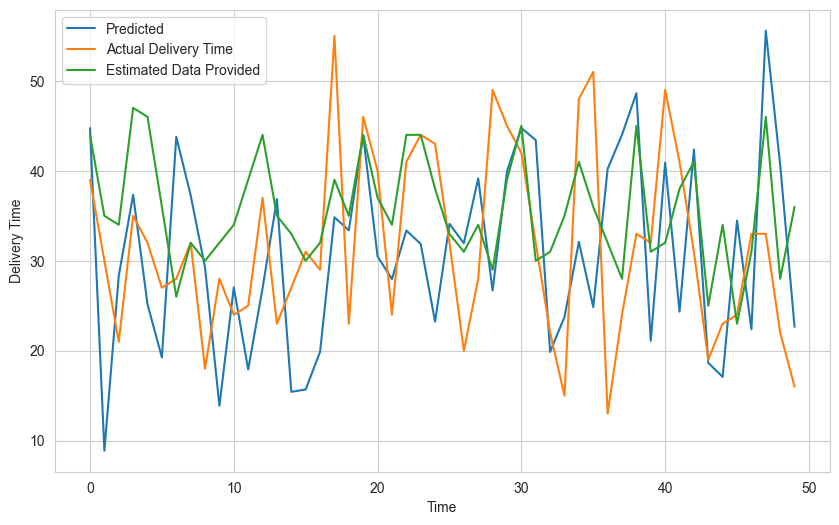

In [71]:
# Predictions
model.eval()
with torch.no_grad():
    y_pred = model(X_test_corrected, current_features_test_corrected)

# Mean absolute error
from sklearn.metrics import mean_absolute_error, mean_squared_error
print(mean_absolute_error(denormalize_target(y_pred.cpu().numpy(), target_column, normalization_parameters), denormalize_target(y_test_corrected.cpu().numpy(), target_column, normalization_parameters)))
print(mean_absolute_error(y_est[window_length:], denormalize_target(y_test_corrected.cpu().numpy(), target_column, normalization_parameters)))

# Plot the training and test data
plt.figure(figsize=(10, 6))
plt.plot(denormalize_target(y_pred.cpu().numpy(), target_column, normalization_parameters)[:50], label='Predicted')
plt.plot(denormalize_target(y_test_corrected.cpu().numpy(), target_column, normalization_parameters)[:50], label='Actual Delivery Time')
plt.plot(y_est[window_length:window_length + 50], label='Estimated Data Provided')
plt.xlabel('Time')
plt.ylabel('Delivery Time')
plt.legend()
plt.show()

## Applying SVD to find the attributes that affect the lateness of the delivery the most

In [342]:
X = df[['HOUR', 'DELI_DISTANCE', 'CLOUD_COVERAGE', 'TEMPERATURE', 'WIND_SPEED']].to_numpy()
y = df['LATE_DELIVERY'].to_numpy()

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids

rus = ClusterCentroids(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# Initialize the Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
rf.fit(X_resampled, y_resampled)

# Get feature importances
importances = rf.feature_importances_

# Sort the feature importances in descending order
sorted_indices = np.argsort(importances)[::-1]

# Print the feature rankings
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(f"{f + 1}. feature {sorted_indices[f]} ({importances[sorted_indices[f]]})")

# Validate the model
from sklearn.metrics import classification_report
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

Feature ranking:
1. feature 3 (0.2763330829521642)
2. feature 0 (0.27521390740519996)
3. feature 1 (0.2389840951954082)
4. feature 4 (0.2025092998967377)
5. feature 2 (0.006959614550489966)
              precision    recall  f1-score   support

       False       0.97      0.28      0.43      3547
        True       0.04      0.80      0.08       139

    accuracy                           0.30      3686
   macro avg       0.51      0.54      0.25      3686
weighted avg       0.94      0.30      0.42      3686



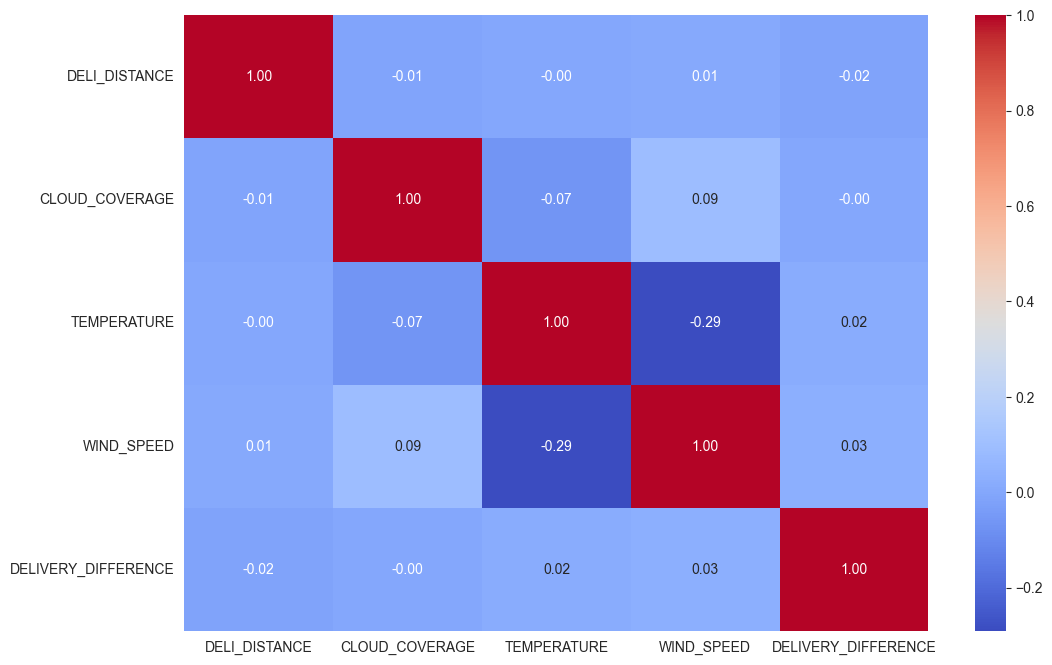

In [97]:
# Calculate correlation matrix
correlation_matrix = df[['DELI_DISTANCE', 'CLOUD_COVERAGE', 'TEMPERATURE', 'WIND_SPEED', 'DELIVERY_DIFFERENCE']].corr()
# Create a heatmap for better visualization
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()
